In [1]:
# Importing necessary libraries and general settings

import pandas as pd
import os
import glob
import math
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import numpy as np
from scipy.signal import find_peaks

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

In [2]:
# Plotting the result obtained during the study
def subplotter(low,high,X,Y,Z,X_inv,Y_inv,Z_inv):
    
    range = np.arange(low,high)
    fig,axs = plt.subplots(3,figsize=(10,15))

    axs[0].plot(range,X[range],label = 'X acquired', color='blue')
    axs[0].plot(range,X_inv[range],label = 'X planning', color='red')
    axs[0].legend() 
    axs[0].set_xlabel('row index (dimension less)')
    axs[0].set_ylabel('X in mm')
    #axs[0].set_title('X data comparison')   
    
    axs[1].plot(range,Y[range], label = 'Y acquired', color='blue')
    axs[1].plot(range,Y_inv[range], label = 'Y planning', color='red') 
    axs[1].legend()
    axs[1].set_xlabel('row index (dimension less)')
    axs[1].set_ylabel('Y in mm')
   # axs[1].set_title('Y data comparison')   
    

    axs[2].plot(range,Z[range], label = 'Z acquired', color='blue')
    axs[2].plot(range,Z_inv[range] , label = 'Z planning', color='red')
    axs[2].legend()
    axs[2].set_xlabel('row index (dimension less)')
    axs[2].set_ylabel('Z in mm')
    #axs[2].set_title('Z data comparison')   
    
    
    fig.canvas.draw()
    fig.canvas.flush_events()


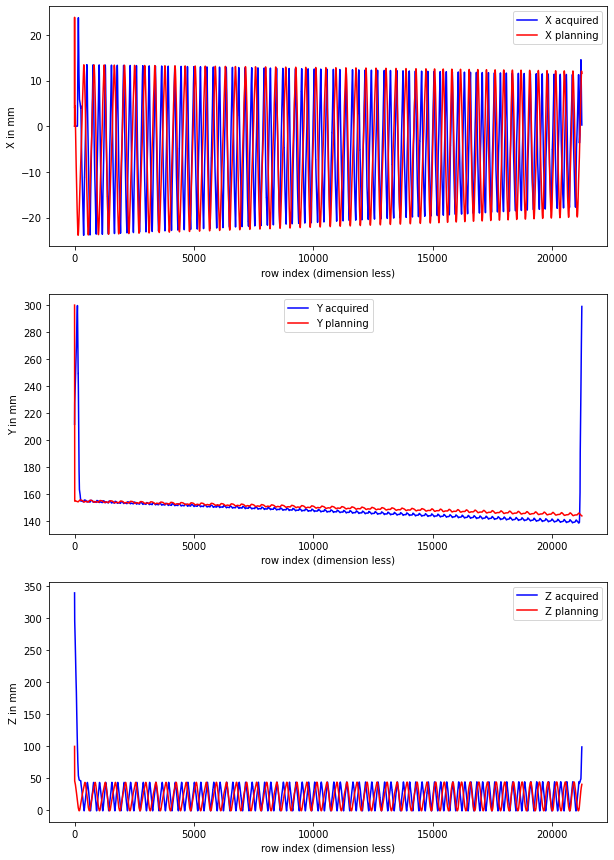

In [3]:
df_m = pd.read_parquet('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Parquet/96-6030-0.parquet')
#df_m = pd.read_parquet('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Parquet/0-1030-0.parquet')
block = 6030
angle = 96-15
df_p = pd.read_csv('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Toolpath/OP6030_TD_and_WD.csv',delimiter= ';')

df_m = df_m.rename(columns=df_m.iloc[0])
df_m = df_m.iloc[1: , :]

tool_tip_X = df_p['X_TTP Q [mm]'].to_numpy()
tool_tip_Y = df_p['Y_TTP  [mm]'].to_numpy()
tool_tip_Z = df_p['Z_TTP  [mm]'].to_numpy()
X_inv=tool_tip_X
Y_inv=tool_tip_Y
Z_inv=tool_tip_Z

wcx = pd.to_numeric(df_m['DynamicData     WcX']).to_numpy()
wcy = pd.to_numeric(df_m['DynamicData     WcY']).to_numpy()
wcz = pd.to_numeric(df_m['DynamicData     WcZ']).to_numpy()

size = wcx.shape[0]
ones = np.ones((size,))
zeros = np.zeros((size,))

init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                  [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                  [zeros,                            zeros,                           ones,  zeros],
                  [zeros,                             zeros,                          zeros, ones]])

machine_points_xyz   = np.array([[wcx],
                                 [wcy],
                                 [wcz],
                                 [ones]])

forward_transformation = np.transpose(init_C, (2,0,1))
tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))

X = tool_position_workpiece_CS[0,0,:]
Y = tool_position_workpiece_CS[1,0,:]
Z = tool_position_workpiece_CS[2,0,:]

subplotter(0,Y.shape[0],X,Y,Z,X_inv,Y_inv,Z_inv)

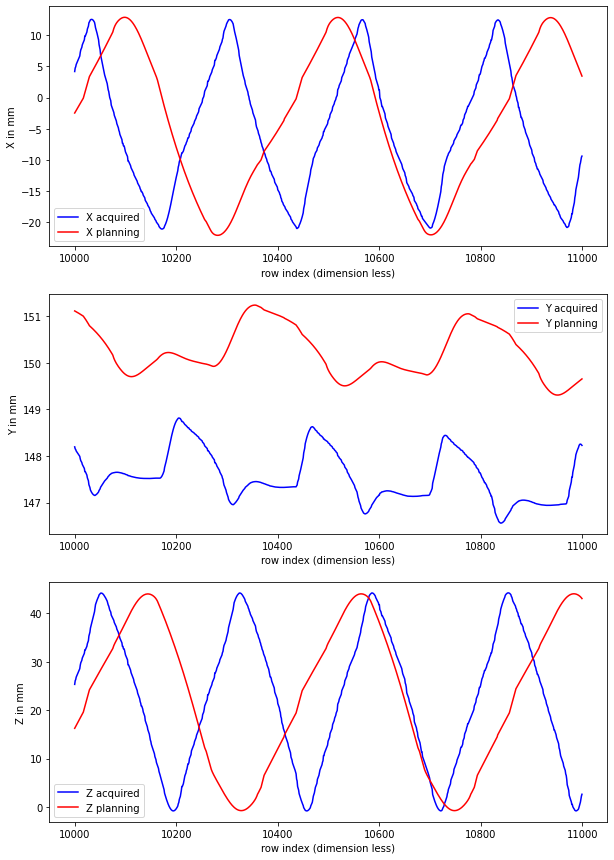

In [4]:
subplotter(10000,11000,X,Y,Z,X_inv,Y_inv,Z_inv)

In [5]:
# Here the distances are calculated, for each aquired data point, forward transformation was performed above,
# and now for each of those poits the disace for all planning points are calculated.
lst1 = []
lst2 = []

dist  = np.zeros(len(tool_tip_X))
print('Enter the tolerance number value, example 3 mm')
#tol = input()
tol = 3
count = 0 
k = 5

for i in np.arange(len(X)):   # 47917
    
    dist = (((tool_tip_X-X[i])**2+(tool_tip_Y-Y[i])**2+(tool_tip_Z-Z[i])**2)**(1/2))
    
    # partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, 
    # we may match up with far way points, which were causing lots of outliers
    
    pos = np.argpartition(dist, k)
    pos = pos[:k]
    min_val = dist[pos]
    #print(pos,min_val)
    
    # the position closest the iterator is considered, since the far away values are thus avoided from matching
    pos = pos[np.argmin(abs(pos - i))]
    min_val = dist[pos]
    
    #print(i,pos,min_val)
    # store both position and the value in two separate lists
    if(abs(min_val<=float(tol))): 
        lst1.append(pos)
        lst2.append(min_val)
        count = count+1
        print(i,pos,min_val,count)
    else:
        lst1.append(np.nan)
        lst2.append(np.nan)
   

Enter the tolerance number value, example 3 mm
243 7 2.770283056889471 1
244 7 2.770283056889471 2
245 7 2.423504783484076 3
246 7 2.3088213118204206 4
247 7 2.1946896594977354 5
248 7 2.081220384711561 6
249 7 1.9685406084789219 7
250 7 1.856763117847747 8
251 7 1.621710600561423 9
252 7 1.4086838338917502 10
253 7 1.3056787831040089 11
254 7 1.2058223902964977 12
255 7 1.1099752574108626 13
256 7 0.8595909854348791 14
257 7 0.7950554540120897 15
258 7 0.7443998240142083 16
259 7 0.7105995046781919 17
260 7 0.6210072194903401 18
261 7 0.2742692518834947 19
262 10 0.4630640327881246 20
263 14 0.46470327013573215 21
264 18 0.46814702244925416 22
265 22 0.47320782821192414 23
266 451 0.2889509265707877 24
267 454 0.26654457804898707 25
268 455 0.23355540429732036 26
269 456 0.3726454728151035 27
270 457 0.3149342244610121 28
271 459 0.23317395661239926 29
272 460 0.37321889357198057 30
273 461 0.3152037218973095 31
274 463 0.3200427582897341 32
275 464 0.43703900995832545 33
276 465 0.37

824 901 0.08933797057477508 582
825 903 0.2407748425271037 583
826 904 0.16511276304943306 584
827 905 0.0899362686809331 585
828 907 0.24170162206927917 586
829 908 0.16616194585425387 587
830 909 0.09071174036699443 588
831 910 0.3182396840194128 589
832 910 0.3182396840194128 590
833 911 0.24233115612693962 591
834 912 0.16687466237659596 592
835 914 0.31906486163452874 593
836 915 0.24309388009488542 594
837 916 0.16749006328388283 595
838 917 0.09193267203844839 596
839 918 0.3197607429514464 597
840 919 0.24401265871841224 598
841 920 0.16823900561317606 599
842 921 0.3964719125936231 600
843 922 0.32050647428176 601
844 924 0.16886324245242093 602
845 925 0.09332290513886128 603
846 925 0.3971954935158202 604
847 926 0.3214617019549934 605
848 927 0.2455013789889572 606
849 928 0.16951366728561948 607
850 929 0.09366060728710766 608
851 929 0.39777273725040685 609
852 930 0.3218653005601188 610
853 931 0.24599394646084877 611
854 932 0.16996150297828358 612
855 933 0.09409733177

1163 999 0.20381412172775928 921
1164 1003 0.2033674530886327 922
1165 1005 0.20308130595949422 923
1166 1009 0.20253358629902082 924
1167 1011 0.20220415335160863 925
1168 1013 0.2018482721959394 926
1169 1015 0.20141972510591577 927
1170 1019 0.20074853200439255 928
1171 1021 0.20046527913619203 929
1172 1025 0.19997747522140513 930
1173 1027 0.1995939243509591 931
1174 1029 0.1994928416094592 932
1175 1031 0.1993815473391115 933
1176 1033 0.19937448628967533 934
1177 1035 0.19959773517145685 935
1178 1037 0.19977778403175533 936
1179 1039 0.19992297844109144 937
1180 1041 0.20027268364599757 938
1181 1043 0.2004647380856934 939
1182 1045 0.20080821482206448 940
1183 1047 0.20086035569205188 941
1184 1049 0.2014154437367248 942
1185 1053 0.20257808688344103 943
1186 1055 0.20308971838451778 944
1187 1057 0.2038093300836076 945
1188 1061 0.20496217346592693 946
1189 1063 0.2054566310991689 947
1190 1065 0.20572895008376665 948
1191 1069 0.20621816709289537 949
1192 1071 0.208507218354

1509 1597 0.20223066370298512 1267
1510 1601 0.20124840653869278 1268
1511 1602 0.23940259487547802 1269
1512 1604 0.18799106529988313 1270
1513 1605 0.20015487944746152 1271
1514 1608 0.18753727956270275 1272
1515 1609 0.19928970134536084 1273
1516 1610 0.23728255956560662 1274
1517 1612 0.1873116963947209 1275
1518 1613 0.19841104419912295 1276
1519 1614 0.23628405201650987 1277
1520 1615 0.2894217378136293 1278
1521 1617 0.19766727592261885 1279
1522 1618 0.23536036030756244 1280
1523 1619 0.2884256259450437 1281
1524 1621 0.19691471630488716 1282
1525 1622 0.2345485830049921 1283
1526 1625 0.19630687427998486 1284
1527 1626 0.23362524766349116 1285
1528 1629 0.19604176544194427 1286
1529 1633 0.195766950485579 1287
1530 1634 0.23246901079208682 1288
1531 1635 0.2851204771261089 1289
1532 1638 0.23196216522521082 1290
1533 1640 0.23419036948149125 1291
1534 1641 0.2319270593029122 1292
1535 1642 0.23147307267092695 1293
1536 1646 0.23220976264971158 1294
1537 1646 0.2322097626497115

1857 2201 0.2547934988101042 1615
1858 2202 0.21191607563335396 1616
1859 1778 0.3877077157995488 1617
1860 2203 0.3738991315678399 1618
1861 2204 0.3109733015300427 1619
1862 2206 0.2127779234062684 1620
1863 1782 0.3885499894194658 1621
1864 2207 0.3740863206765306 1622
1865 2208 0.311184844073833 1623
1866 1786 0.38941760896044814 1624
1867 2211 0.3741262805947914 1625
1868 2212 0.31147287698786646 1626
1869 2213 0.25631840382180643 1627
1870 2214 0.2143221576683382 1628
1871 2215 0.37423193799502996 1629
1872 2216 0.31180403892359476 1630
1873 2217 0.2567733356533771 1631
1874 2218 0.2151289740674556 1632
1875 1794 0.39159826784227714 1633
1876 2219 0.37413855767408505 1634
1877 2221 0.25715486203554694 1635
1878 2222 0.21587781015989455 1636
1879 1798 0.39308419820829166 1637
1880 2223 0.37412688286487816 1638
1881 2224 0.3120417735983436 1639
1882 2225 0.2575087861037644 1640
1883 2226 0.21651235846432287 1641
1884 1802 0.3941574212594166 1642
1885 2227 0.3743248988855069 1643
18

2206 2725 0.24946520407936842 1964
2207 2727 0.25016926884449026 1965
2208 2731 0.2510377808041082 1966
2209 2733 0.25158335186660863 1967
2210 2735 0.2518121913715855 1968
2211 2737 0.25201014315726306 1969
2212 2739 0.2520266933194928 1970
2213 2741 0.2520602924698888 1971
2214 2743 0.2517983579847463 1972
2215 2745 0.25163906911604417 1973
2216 2747 0.25124075279726 1974
2217 2751 0.2502825959952397 1975
2218 2753 0.24962877248505105 1976
2219 2755 0.24903082301667628 1977
2220 2757 0.24798289463548243 1978
2221 2761 0.24592526492840205 1979
2222 2763 0.24471687649566065 1980
2223 2765 0.24327910561198104 1981
2224 2767 0.24177694579589634 1982
2225 2772 0.23780846734946648 1983
2226 2775 0.21427045756456603 1984
2227 2776 0.23991242053237993 1985
2228 2780 0.2393223889324913 1986
2229 2781 0.2812333516291463 1987
2230 2783 0.26148398658016414 1988
2231 2783 0.27950472856687064 1989
2232 2785 0.27768669022738046 1990
2233 2786 0.20997023772412673 1991
2234 2789 0.21823114874222616 1

2545 3282 0.24721727161957746 2303
2546 3284 0.26504726150931196 2304
2547 3286 0.2650681654938204 2305
2548 3286 0.24440133804664277 2306
2549 2864 0.38206217743530074 2307
2550 3288 0.2656564767025735 2308
2551 3288 0.2433477168697305 2309
2552 3290 0.26615223439197216 2310
2553 3292 0.18941451221637642 2311
2554 3293 0.20227987042232576 2312
2555 3294 0.2405337915882128 2313
2556 3296 0.18884819521584476 2314
2557 3298 0.23943028941076563 2315
2558 3300 0.18844364238196382 2316
2559 3301 0.20023008190181785 2317
2560 3302 0.2381700089524177 2318
2561 3304 0.1877328883224611 2319
2562 3305 0.19938259971802688 2320
2563 3308 0.1871249978023839 2321
2564 3309 0.19835046887041838 2322
2565 3310 0.23621186862387836 2323
2566 3311 0.2891185480538946 2324
2567 3313 0.19780971892445295 2325
2568 3315 0.28814279864512804 2326
2569 3317 0.19679178637796235 2327
2570 3318 0.2342736063231975 2328
2571 3319 0.2870614179902429 2329
2572 3321 0.19636316704139128 2330
2573 3322 0.2335739028887662 2

2887 3425 0.38098014606169867 2645
2888 3848 0.3707243338797335 2646
2889 3850 0.2490466884794355 2647
2890 3851 0.20406375679997732 2648
2891 3852 0.37095555452821954 2649
2892 3853 0.306763719465606 2650
2893 3854 0.24957639213279587 2651
2894 3433 0.38166334816047326 2652
2895 3857 0.30730858097256053 2653
2896 3858 0.25012007420170823 2654
2897 3859 0.20558266631705435 2655
2898 3437 0.381994756543401 2656
2899 3860 0.3718893197657171 2657
2900 3861 0.30787617576505116 2658
2901 3863 0.2061161086604733 2659
2902 3441 0.38255009959077285 2660
2903 3864 0.37241513865763914 2661
2904 3865 0.3084193721788265 2662
2905 3866 0.25147587556014145 2663
2906 3445 0.38282349012227085 2664
2907 3868 0.3727808080459992 2665
2908 3869 0.3091299929783898 2666
2909 3870 0.2520975645815977 2667
2910 3871 0.20780122975540852 2668
2911 3874 0.25264224352518266 2669
2912 3874 0.25264224352518266 2670
2913 3875 0.20847982810724083 2671
2914 3453 0.3839555236238634 2672
2915 3876 0.3734923409707231 2673

3225 3930 0.3964234744293836 2983
3226 4353 0.3738811596108154 2984
3227 4354 0.3119849302613152 2985
3228 4355 0.25822662983724104 2986
3229 4356 0.21826974899164073 2987
3230 4357 0.37364121544068735 2988
3231 4358 0.312097329381568 2989
3232 4361 0.2035767413580602 2990
3233 4362 0.2278536088381865 2991
3234 4363 0.20296788818702685 2992
3235 4364 0.25866409707709076 2993
3236 4366 0.21941563885875387 2994
3237 4367 0.37225850565106106 2995
3238 4368 0.3109839398001627 2996
3239 4369 0.25829905345119514 2997
3240 4372 0.3108270659933141 2998
3241 4373 0.25828134884521453 2999
3242 4374 0.22001456856183696 3000
3243 4376 0.2591116625536554 3001
3244 4378 0.20458695531313828 3002
3245 4379 0.22444255959034606 3003
3246 4381 0.2270021433075249 3004
3247 4384 0.22446328279207475 3005
3248 4386 0.22098089831890827 3006
3249 4388 0.21888533969959048 3007
3250 4390 0.21726162758027148 3008
3251 4394 0.21523223028735336 3009
3252 4398 0.2131424143555685 3010
3253 4400 0.2121935988166898 301

3559 4916 0.22759442258847165 3317
3560 4918 0.21461013765673012 3318
3561 4919 0.20359478781028792 3319
3562 4920 0.22591758167556852 3320
3563 4922 0.2140247980986085 3321
3564 4924 0.22441816748252427 3322
3565 4926 0.21409072044115166 3323
3566 4927 0.20139212864770697 3324
3567 4928 0.22297774007184507 3325
3568 4930 0.21374049920452984 3326
3569 4932 0.22136247348612922 3327
3570 4934 0.21376598991566192 3328
3571 4935 0.19915037762097296 3329
3572 4936 0.21989087390264228 3330
3573 4939 0.1987166183855823 3331
3574 4940 0.2187573292739765 3332
3575 4941 0.25978343802017806 3333
3576 4942 0.1996585155318846 3334
3577 4943 0.21744610191707384 3335
3578 4947 0.2162542489769993 3336
3579 4948 0.2566097451312316 3337
3580 4950 0.19596524981825475 3338
3581 4951 0.21457724716840768 3339
3582 4952 0.2551551392084903 3340
3583 4954 0.19496908056412446 3341
3584 4955 0.2132979191212991 3342
3585 4956 0.2536446251226341 3343
3586 4958 0.1947241939067362 3344
3587 4960 0.25231483859817805 

3900 5433 0.28642285813075163 3658
3901 5435 0.19606542174279235 3659
3902 5436 0.2330535495629085 3660
3903 5437 0.28557025114381757 3661
3904 5439 0.19581668790818865 3662
3905 5440 0.2323767662802352 3663
3906 5443 0.19562863425637902 3664
3907 5444 0.23190881090192336 3665
3908 5445 0.2844593217425624 3666
3909 5446 0.23444787690761 3667
3910 5447 0.23178966552879374 3668
3911 5451 0.19269985029101147 3669
3912 5452 0.23232294884982593 3670
3913 5456 0.19252634121489579 3671
3914 5456 0.19252634121489579 3672
3915 5458 0.19252782423775597 3673
3916 5460 0.19245129685867737 3674
3917 5462 0.1923317952976924 3675
3918 5464 0.1924177601779216 3676
3919 5466 0.19249954415548354 3677
3920 5468 0.19220137364187814 3678
3921 5470 0.19231442900008078 3679
3922 5472 0.19241608503633006 3680
3923 5480 0.19251096869735856 3681
3924 5480 0.19251096869735856 3682
3925 5482 0.1927833892586649 3683
3926 5486 0.19291743337290687 3684
3927 5488 0.19329421431527308 3685
3928 5490 0.1936426352901035 

4238 5972 0.3735458186251595 3996
4239 5973 0.3096028221273341 3997
4240 5974 0.25256679902292417 3998
4241 5975 0.20802494779904088 3999
4242 5555 0.3835257377566113 4000
4243 5976 0.3739613361721447 4001
4244 5978 0.2531499742749656 4002
4245 5979 0.20867371349963865 4003
4246 5559 0.38410134414871994 4004
4247 5980 0.37438312236117005 4005
4248 5981 0.3107046703513629 4006
4249 5982 0.25375209010955746 4007
4250 5563 0.3844594356485336 4008
4251 5984 0.37483242468514333 4009
4252 5985 0.3110853239381401 4010
4253 5986 0.254286379927803 4011
4254 5987 0.21018080623725088 4012
4255 5990 0.2547592528731749 4013
4256 5991 0.2110269129748841 4014
4257 5571 0.38592097013316506 4015
4258 5993 0.31157278255683 4016
4259 5996 0.37524440100601825 4017
4260 5997 0.3119808461653074 4018
4261 5998 0.25566973293350226 4019
4262 5999 0.21248253631610992 4020
4263 6000 0.37520561759531534 4021
4264 6001 0.3121732327410985 4022
4265 6002 0.256243115994593 4023
4266 6003 0.2132425146258228 4024
4267 

4584 6483 0.2593367878781932 4342
4585 6485 0.20483320565488328 4343
4586 6486 0.22455338704777505 4344
4587 6488 0.2271839644104889 4345
4588 6491 0.22441945337484434 4346
4589 6493 0.22121246664151398 4347
4590 6495 0.2189982882576866 4348
4591 6497 0.21769283423435762 4349
4592 6499 0.21637174474054033 4350
4593 6501 0.21519357755021865 4351
4594 6503 0.2142311308058729 4352
4595 6505 0.21324438070666746 4353
4596 6507 0.21206794825935887 4354
4597 6513 0.20965973497475396 4355
4598 6515 0.2087671846190071 4356
4599 6518 0.24838433806954413 4357
4600 6520 0.24926782641215575 4358
4601 6522 0.25020416608913326 4359
4602 6526 0.2515919514814407 4360
4603 6528 0.2522046773521402 4361
4604 6530 0.25256126111329197 4362
4605 6532 0.2529374986618705 4363
4606 6534 0.25329935500210204 4364
4607 6536 0.25336322584228677 4365
4608 6538 0.253485629657787 4366
4609 6540 0.25342456354114523 4367
4610 6542 0.25342069613593365 4368
4611 6544 0.2530204718132529 4369
4612 6546 0.252551153661227 437

4922 7045 0.2186133367929331 4680
4923 7046 0.26000458793218345 4681
4924 7047 0.31419080716816433 4682
4925 7048 0.21756526774139767 4683
4926 7049 0.2582987249775092 4684
4927 7053 0.25671900817800486 4685
4928 7053 0.25671900817800486 4686
4929 7056 0.21472367918606133 4687
4930 7057 0.2553378614278411 4688
4931 7060 0.2135065597162859 4689
4932 7061 0.2540173323009784 4690
4933 7063 0.19501991431139531 4691
4934 7064 0.2125247620789216 4692
4935 7065 0.2523704691074388 4693
4936 7067 0.19401973865895392 4694
4937 7068 0.21119764100929342 4695
4938 7069 0.25119506354316457 4696
4939 7071 0.1931262822795355 4697
4940 7072 0.21000595959366866 4698
4941 7073 0.24986221974064132 4699
4942 6653 0.38467160129547245 4700
4943 7075 0.2482693998090186 4701
4944 6655 0.38381157951379596 4702
4945 7077 0.25952099893383046 4703
4946 7077 0.24699076696386305 4704
4947 6657 0.3831710962049014 4705
4948 7079 0.25976345233642817 4706
4949 7079 0.24569999367706957 4707
4950 7081 0.2598953828346228 4

5267 7567 0.2323078256587857 5025
5268 7569 0.23242226901630306 5026
5269 7571 0.23243165416492623 5027
5270 7573 0.23249149334141933 5028
5271 7579 0.23281788325193725 5029
5272 7581 0.23251906075423714 5030
5273 7583 0.23272675398534606 5031
5274 7589 0.2335729859731582 5032
5275 7591 0.23377051555623096 5033
5276 7593 0.23426807719302914 5034
5277 7597 0.23527596836892423 5035
5278 7599 0.23568490723512978 5036
5279 7601 0.23637298478055604 5037
5280 7607 0.23837428297234808 5038
5281 7609 0.23925254656474118 5039
5282 7611 0.23997155420170338 5040
5283 7613 0.2406339103835647 5041
5284 7615 0.24153097644006472 5042
5285 7617 0.24248423004432998 5043
5286 7619 0.24314678851607927 5044
5287 7623 0.24454955039700263 5045
5288 7623 0.24454955039700263 5046
5289 7625 0.2453010902346659 5047
5290 7627 0.24609034978200578 5048
5291 7629 0.24666755016773223 5049
5292 7631 0.24728508517883913 5050
5293 7633 0.2477784819182968 5051
5294 7636 0.2030607123222874 5052
5295 7638 0.30682797113973

5608 8103 0.21161719853467886 5366
5609 8104 0.37450871279644493 5367
5610 8105 0.3112382062675636 5368
5611 8106 0.25535285520256845 5369
5612 8107 0.21230960084145684 5370
5613 8108 0.37486886536741343 5371
5614 8109 0.31166796905238503 5372
5615 8110 0.25583836876341964 5373
5616 8111 0.2131149684379995 5374
5617 7690 0.3881732661365667 5375
5618 8112 0.37492682599270827 5376
5619 8113 0.3120262286887899 5377
5620 8115 0.21391867446052337 5378
5621 8117 0.31223756605083786 5379
5622 8118 0.25689297574251346 5380
5623 8119 0.2146678794792805 5381
5624 8120 0.37515462020912793 5382
5625 8122 0.25726247402891306 5383
5626 8123 0.21529080835947378 5384
5627 7702 0.3909861324771145 5385
5628 8125 0.31274402072578583 5386
5629 8127 0.21604145310047623 5387
5630 7706 0.39211125752828235 5388
5631 8128 0.37529332374834157 5389
5632 8129 0.3129245718951441 5390
5633 8131 0.21671098406797623 5391
5634 8132 0.3752054893578564 5392
5635 8133 0.3129027334346865 5393
5636 8135 0.21720620012796615

5943 8588 0.25746815504270404 5701
5944 8591 0.2074515835392594 5702
5945 8591 0.2074515835392594 5703
5946 8592 0.22358237170728826 5704
5947 8594 0.21056699100350595 5705
5948 8596 0.20694216735494766 5706
5949 8602 0.2049900824782688 5707
5950 8604 0.20468424961488713 5708
5951 8606 0.20447812980752744 5709
5952 8612 0.20356024547055604 5710
5953 8614 0.20332198622888997 5711
5954 8616 0.20274997472319287 5712
5955 8618 0.20253700772337727 5713
5956 8620 0.20214055855160842 5714
5957 8622 0.20166149490515287 5715
5958 8624 0.20142811594548737 5716
5959 8626 0.20114975580231806 5717
5960 8628 0.20084479456950052 5718
5961 8630 0.2006575865355504 5719
5962 8632 0.20036987744828738 5720
5963 8636 0.20006532606049737 5721
5964 8638 0.19988044435342037 5722
5965 8640 0.2000328265225288 5723
5966 8642 0.20004031066729505 5724
5967 8644 0.20020055927053318 5725
5968 8646 0.2006825633696076 5726
5969 8650 0.201317054410868 5727
5970 8652 0.20170189154047255 5728
5971 8654 0.2021274542069210

6284 9162 0.21487396283984647 6042
6285 9163 0.2553020517799382 6043
6286 9166 0.21343641097610908 6044
6287 9167 0.25348999732643407 6045
6288 9169 0.19405724155136125 6046
6289 9170 0.21201460225740307 6047
6290 9171 0.2520623487046578 6048
6291 9173 0.1933379560923046 6049
6292 9174 0.21060366823301274 6050
6293 9175 0.2507485712387012 6051
6294 9177 0.19234988351442842 6052
6295 9178 0.256597360513572 6053
6296 9180 0.25667462938960844 6054
6297 8761 0.38382582924713643 6055
6298 9182 0.2567755862307954 6056
6299 8763 0.38311186121213575 6057
6300 8763 0.38311186121213575 6058
6301 9184 0.2570129352167633 6059
6302 9186 0.2439463235371481 6060
6303 8767 0.3818038982089464 6061
6304 9188 0.25744536793491973 6062
6305 9188 0.24265875503240977 6063
6306 9189 0.1897784777063216 6064
6307 9191 0.24153287306540472 6065
6308 9193 0.18808915213908897 6066
6309 9194 0.20190746945423046 6067
6310 9195 0.24033784792802454 6068
6311 9197 0.1874602671980618 6069
6312 9198 0.20056107027301015 60

6611 9687 0.19309802883908517 6369
6612 9691 0.1932388936404915 6370
6613 9693 0.19348385948388944 6371
6614 9695 0.1937044820745952 6372
6615 9697 0.19387301522767234 6373
6616 9699 0.19419560579029502 6374
6617 9701 0.19466770337143185 6375
6618 9703 0.1948581085231229 6376
6619 9705 0.19530911050267685 6377
6620 9707 0.19566178741259566 6378
6621 9709 0.19630493242969288 6379
6622 9711 0.19681587145066873 6380
6623 9713 0.19726525617680832 6381
6624 9715 0.197886274931428 6382
6625 9717 0.19825115695082784 6383
6626 9723 0.2000348518931035 6384
6627 9723 0.2000348518931035 6385
6628 9725 0.20047014782650655 6386
6629 9727 0.20101790378963758 6387
6630 9729 0.20153938611873293 6388
6631 9731 0.2020147112505702 6389
6632 9733 0.2023879903414252 6390
6633 9735 0.20275496344472035 6391
6634 9737 0.20302734767045524 6392
6635 9738 0.2485179013105009 6393
6636 9741 0.20358425083681791 6394
6637 9743 0.25038308737340126 6395
6638 9325 0.38166600973583664 6396
6639 9746 0.1990855903332009 6

6950 9796 0.3890346586676108 6708
6951 10217 0.3127053235921373 6709
6952 10218 0.25725730531883173 6710
6953 9800 0.3899309398754154 6711
6954 10220 0.3757398716045467 6712
6955 10221 0.3130015846734506 6713
6956 10222 0.25762106384192074 6714
6957 10223 0.21540067189260653 6715
6958 9804 0.39098663087434027 6716
6959 10224 0.37574210030721733 6717
6960 10225 0.3132244199977582 6718
6961 10227 0.21610635520433374 6719
6962 10227 0.21610635520433374 6720
6963 9808 0.3918310526335263 6721
6964 10228 0.3758730216371337 6722
6965 10229 0.313332025433711 6723
6966 10230 0.258367062670743 6724
6967 10231 0.2167408418377069 6725
6968 9812 0.39276309181679847 6726
6969 10232 0.3756639353223764 6727
6970 10233 0.313303408452579 6728
6971 10234 0.258651542950878 6729
6972 10235 0.21729300253254352 6730
6973 9816 0.39402494386265124 6731
6974 10236 0.3754407580210115 6732
6975 10237 0.31346555335671705 6733
6976 10238 0.25891943793957906 6734
6977 10239 0.21794163625251387 6735
6978 10240 0.3754

7290 10727 0.2510764299129833 7048
7291 10729 0.25186943310308546 7049
7292 10731 0.2524948757203478 7050
7293 10733 0.2531556696513063 7051
7294 10735 0.2537854105984391 7052
7295 10739 0.254642439914992 7053
7296 10739 0.254642439914992 7054
7297 10741 0.25467890590729253 7055
7298 10743 0.2549352671854322 7056
7299 10745 0.25490753971072905 7057
7300 10747 0.25496219472709636 7058
7301 10749 0.25471281043843336 7059
7302 10751 0.2543346010026723 7060
7303 10753 0.2539333548364939 7061
7304 10755 0.2534774044585622 7062
7305 10757 0.2527175833495937 7063
7306 10759 0.25181944452121185 7064
7307 10763 0.2502044195355962 7065
7308 10765 0.24904319361276195 7066
7309 10767 0.2476650683384613 7067
7310 10769 0.24620499789481584 7068
7311 10773 0.24345159873025618 7069
7312 10777 0.2113941911528096 7070
7313 10778 0.23872465240172583 7071
7314 10779 0.2815852109963377 7072
7315 10781 0.21322200467162541 7073
7316 10784 0.2153368051507445 7074
7317 10785 0.2397464840485435 7075
7318 10787 

7628 11281 0.24621001197723913 7386
7629 11283 0.25372680945136056 7387
7630 11283 0.24493574218946373 7388
7631 10865 0.38240783379503274 7389
7632 11285 0.2543013655059229 7390
7633 11285 0.2434001562771482 7391
7634 11287 0.25478512737064957 7392
7635 11287 0.24230295833559762 7393
7636 11289 0.18822580463471095 7394
7637 11290 0.20256183389452767 7395
7638 11291 0.24091191949514998 7396
7639 11293 0.18772282857090278 7397
7640 11294 0.201268079684359 7398
7641 11295 0.23977339343857387 7399
7642 11297 0.18715305198786045 7400
7643 11298 0.20022985540213678 7401
7644 11299 0.2385101785580559 7402
7645 11301 0.18618540171788878 7403
7646 11302 0.19920255294280836 7404
7647 11306 0.19843085286733678 7405
7648 11307 0.23647467087351234 7406
7649 11309 0.18532733483284108 7407
7650 11310 0.1974741945289034 7408
7651 11311 0.23559161639094053 7409
7652 11315 0.23430605195081255 7410
7653 11315 0.23430605195081255 7411
7654 11317 0.18483441224255884 7412
7655 11318 0.19582635414000654 741

7960 11825 0.24566371249101773 7718
7961 11827 0.24640164913619952 7719
7962 11829 0.24718292627432037 7720
7963 11831 0.24774959489400614 7721
7964 11835 0.24886393851843366 7722
7965 11838 0.24941478175667486 7723
7966 11841 0.20452017040461973 7724
7967 11423 0.38172988469526514 7725
7968 11844 0.3088587901245508 7726
7969 11427 0.38196991483121884 7727
7970 11848 0.3091419595156265 7728
7971 11849 0.2516370978187873 7729
7972 11431 0.38247100912764503 7730
7973 11431 0.38247100912764503 7731
7974 11852 0.309442697752752 7732
7975 11853 0.2523119585292356 7733
7976 11854 0.20716384282930514 7734
7977 11856 0.3103662062153372 7735
7978 11857 0.25301237193991327 7736
7979 11858 0.2081068784372871 7737
7980 11860 0.31113942011266027 7738
7981 11861 0.25377522509020045 7739
7982 11862 0.20887651881140548 7740
7983 11443 0.3842311430277897 7741
7984 11864 0.3116150356887413 7742
7985 11865 0.25434496225031106 7743
7986 11866 0.20967631971328624 7744
7987 11447 0.38480080433074465 7745
79

8300 12347 0.31444111439073946 8058
8301 12348 0.26036397312475745 8059
8302 11930 0.39742068172296113 8060
8303 12350 0.37613596515921244 8061
8304 12351 0.31435247823664697 8062
8305 12352 0.2604080048776102 8063
8306 12353 0.2203103176282196 8064
8307 11934 0.39892858117746177 8065
8308 12356 0.202987680997826 8066
8309 12357 0.2601751881673285 8067
8310 12358 0.2601268704008654 8068
8311 12359 0.2207088586988075 8069
8312 12360 0.20407312504475333 8070
8313 12361 0.313257756468898 8071
8314 12362 0.26005979046809446 8072
8315 12363 0.2209600454476886 8073
8316 12364 0.37338117116281544 8074
8317 12365 0.3122219308487069 8075
8318 12367 0.2210424801451756 8076
8319 12368 0.22119898622001097 8077
8320 12381 0.2192071254784438 8078
8321 12381 0.2192071254784438 8079
8322 12385 0.21664524579624234 8080
8323 12387 0.21537931835586016 8081
8324 12389 0.21437568561787695 8082
8325 12393 0.21216279861424076 8083
8326 12397 0.21046994600814703 8084
8327 12399 0.20944810299573755 8085
8328 1

8633 12904 0.21195476743582373 8391
8634 12905 0.20476929808321492 8392
8635 12906 0.227321113550191 8393
8636 12910 0.22548064257572753 8394
8637 12913 0.2022529544762658 8395
8638 12914 0.22412693279895696 8396
8639 12917 0.20065400791331792 8397
8640 12920 0.21036228987805905 8398
8641 12921 0.19979495388321566 8399
8642 12924 0.21009169062234984 8400
8643 12925 0.19861437466221127 8401
8644 12926 0.21933921508910617 8402
8645 12928 0.20996833290743122 8403
8646 12929 0.19771369487789892 8404
8647 12931 0.21447574244320614 8405
8648 12932 0.19675549775243664 8406
8649 12933 0.21651395366801615 8407
8650 12934 0.2576875977981365 8408
8651 12937 0.21534969850620672 8409
8652 12938 0.256234845885614 8410
8653 12940 0.19536117777585993 8411
8654 12941 0.21417246014947178 8412
8655 12942 0.2546623699128678 8413
8656 12944 0.19484556087901228 8414
8657 12945 0.21302885122386542 8415
8658 12949 0.21137192187400342 8416
8659 12949 0.21137192187400342 8417
8660 12950 0.2518313926432255 8418


8970 13431 0.344491319019553 8728
8971 13432 0.28286713550857623 8729
8972 13433 0.2830887638664304 8730
8973 13434 0.28399521418633417 8731
8974 13437 0.23211150982966725 8732
8975 13439 0.17805605223637028 8733
8976 13440 0.23291454731297345 8734
8977 13442 0.2328474936165512 8735
8978 13444 0.2329050703418122 8736
8979 13448 0.2330882208683425 8737
8980 13450 0.23303247738898886 8738
8981 13454 0.23340234312399413 8739
8982 13458 0.23355666357384844 8740
8983 13460 0.23365389732018854 8741
8984 13462 0.23380053609255322 8742
8985 13468 0.23478612101949428 8743
8986 13470 0.23516161223158671 8744
8987 13472 0.23553263748325465 8745
8988 13478 0.2369946310913232 8746
8989 13480 0.23764271797907385 8747
8990 13486 0.23984038422404053 8748
8991 13486 0.23984038422404053 8749
8992 13488 0.24062732993263614 8750
8993 13494 0.24288207158760222 8751
8994 13496 0.24363120368677688 8752
8995 13498 0.244533869086807 8753
8996 13502 0.2459687596401239 8754
8997 13504 0.24689961809285452 8755
89

9312 13559 0.3871526050113041 9070
9313 13978 0.3137633676684197 9071
9314 13979 0.25717149901912456 9072
9315 13980 0.2134621985979005 9073
9316 13563 0.3877063786556082 9074
9317 13981 0.37728430026645304 9075
9318 13984 0.21407169918861318 9076
9319 13567 0.3884240103026639 9077
9320 13985 0.37729890621595785 9078
9321 13986 0.3141847512901722 9079
9322 13987 0.25813733851222775 9080
9323 13988 0.21486613191822213 9081
9324 13989 0.37746878541327655 9082
9325 13990 0.3143271242284087 9083
9326 13991 0.25857825350736485 9084
9327 13992 0.2156504780543408 9085
9328 13575 0.38988894498198706 9086
9329 13993 0.37756330036880803 9087
9330 13994 0.3146408854671664 9088
9331 13579 0.3906636675090911 9089
9332 13998 0.31473427958023487 9090
9333 14000 0.2169139947347564 9091
9334 14000 0.2169139947347564 9092
9335 14001 0.3774903464275361 9093
9336 14002 0.31504204324904456 9094
9337 14003 0.25967710716547404 9095
9338 14004 0.21764205663337405 9096
9339 13587 0.3925605866977188 9097
9340 1

9654 14506 0.254498173877515 9412
9655 14508 0.25496805247406135 9413
9656 14512 0.25567829992993296 9414
9657 14514 0.25588355487393155 9415
9658 14516 0.25581853878594996 9416
9659 14518 0.2558791308424744 9417
9660 14520 0.25590535111281204 9418
9661 14522 0.25545929857524835 9419
9662 14524 0.2550173395373092 9420
9663 14526 0.2546168236223625 9421
9664 14528 0.25391645613457253 9422
9665 14530 0.25321296233762197 9423
9666 14532 0.2524238023451883 9424
9667 14534 0.25161114989502564 9425
9668 14538 0.24909848259524803 9426
9669 14540 0.247750929633217 9427
9670 14542 0.24644488165354003 9428
9671 14544 0.24477414923173255 9429
9672 14546 0.2429918266397689 9430
9673 14548 0.24085151005426203 9431
9674 14551 0.2120470214434261 9432
9675 14552 0.2119244075830973 9433
9676 14553 0.22993577185767006 9434
9677 14554 0.21498788246762104 9435
9678 14555 0.23976870020223479 9436
9679 14558 0.4021472943548386 9437
9680 14559 0.2779903076491384 9438
9681 14560 0.40014059973572347 9439
9682 

9990 15017 0.3001577500659844 9748
9991 15019 0.20779994049398293 9749
9992 15019 0.20779994049398293 9750
9993 14635 0.4026753161923642 9751
9994 15021 0.20792935432726564 9752
9995 15021 0.2973034931895686 9753
9996 14638 0.3859887547707545 9754
9997 15023 0.29584151051092594 9755
9998 14640 0.3945098050037293 9756
9999 14642 0.38614341198969193 9757
10000 15025 0.29445613065937104 9758
10001 15027 0.29316435210832054 9759
10002 14648 0.3923664429725459 9760
10003 15029 0.2918574410660635 9761
10004 14652 0.391196442062172 9762
10005 14654 0.3861154534554522 9763
10006 15031 0.29065976362615475 9764
10007 14656 0.39037277935595094 9765
10008 14658 0.38639739787219424 9766
10009 15033 0.2894332288677787 9767
10010 14660 0.389346434267869 9768
10011 14664 0.3885781219842223 9769
10012 15037 0.28708556989488654 9770
10013 14668 0.38765858381874074 9771
10014 14670 0.3869939537646394 9772
10015 14672 0.38715034899555956 9773
10016 14674 0.3877874479806574 9774
10017 15041 0.2851396326864

10323 15470 0.24334825789494602 10081
10324 15474 0.24478212542000874 10082
10325 15476 0.24562885261910933 10083
10326 15478 0.24630404735463543 10084
10327 15480 0.2471347024221049 10085
10328 15482 0.2477722046873513 10086
10329 15484 0.24860263947531566 10087
10330 15486 0.24901379310766908 10088
10331 15488 0.24958359581148842 10089
10332 15490 0.24999909744779308 10090
10333 15492 0.17969364090298992 10091
10334 15493 0.2048112869901342 10092
10335 15494 0.2507033982251595 10093
10336 15497 0.2308081118907594 10094
10337 15497 0.25162488677439393 10095
10338 15498 0.20610529281636297 10096
10339 15137 0.3823976390331173 10097
10340 15500 0.19637483258948818 10098
10341 15500 0.3099241760418625 10099
10342 15502 0.20671582109205489 10100
10343 15141 0.38293771962650847 10101
10344 15504 0.3102923930507497 10102
10345 15505 0.25271465096716256 10103
10346 15145 0.3833437416719254 10104
10347 15507 0.3740672770188214 10105
10348 15508 0.3099037963948192 10106
10349 15509 0.252675814

10665 15930 0.21827957563639505 10423
10666 15931 0.3770893022367689 10424
10667 15932 0.3147564520860955 10425
10668 15933 0.2603224927345383 10426
10669 15936 0.31476402823851185 10427
10670 15937 0.260379462385605 10428
10671 15938 0.21942091284073886 10429
10672 15577 0.39602413134587355 10430
10673 15939 0.3766243482562328 10431
10674 15941 0.260553328290209 10432
10675 15942 0.21986963966247627 10433
10676 15944 0.31450029941345803 10434
10677 15945 0.260340570195543 10435
10678 15946 0.22023692413931525 10436
10679 15585 0.3981754510475838 10437
10680 15947 0.375830346391392 10438
10681 15949 0.2604675542325531 10439
10682 15951 0.20329734003437072 10440
10683 15953 0.3137735053911198 10441
10684 15953 0.3137735053911198 10442
10685 15956 0.2211088592356099 10443
10686 15957 0.20422788996504107 10444
10687 15957 0.37485407549620725 10445
10688 15958 0.313599067894323 10446
10689 15959 0.26057598350855005 10447
10690 15960 0.22153426599258677 10448
10691 15961 0.20516263859214892

11003 16058 0.42023152489948185 10761
11004 16421 0.24639738690888274 10762
11005 16421 0.2816123145502597 10763
11006 16060 0.418225908944932 10764
11007 16423 0.2455287438613363 10765
11008 16062 0.41605704184763953 10766
11009 16425 0.2447926712203359 10767
11010 16064 0.41397732414916355 10768
11011 16427 0.2439211211970797 10769
11012 16427 0.27647344788573186 10770
11013 16066 0.4118820122129978 10771
11014 16429 0.24335297319281243 10772
11015 16068 0.4096191954544112 10773
11016 16431 0.24289008646837987 10774
11017 16431 0.2729510149664143 10775
11018 16070 0.4073091925418252 10776
11019 16433 0.27106606922061394 10777
11020 16072 0.40516444185309286 10778
11021 16435 0.24296274025474163 10779
11022 16435 0.26917069552295286 10780
11023 16074 0.40282461090104626 10781
11024 16437 0.24350281429950346 10782
11025 16076 0.4009239418777093 10783
11026 16439 0.24440018013019607 10784
11027 16439 0.26580542569294485 10785
11028 16078 0.3987988132527894 10786
11029 16441 0.2454036308

11346 16483 0.37837325652687237 11104
11347 16846 0.23410070996730148 11105
11348 16485 0.37785681752136807 11106
11349 16848 0.25248244646813656 11107
11350 16848 0.2332200586160256 11108
11351 16487 0.37753474340092724 11109
11352 16850 0.2536989125580627 11110
11353 16850 0.23199000494483393 11111
11354 16852 0.2555369216267556 11112
11355 16852 0.23093980092369126 11113
11356 16491 0.37746859234105756 11114
11357 16854 0.23016721232863382 11115
11358 16493 0.3774027061244601 11116
11359 16855 0.34420671550403364 11117
11360 16856 0.2290262272647408 11118
11361 16857 0.19232538015218528 11119
11362 16860 0.23066720012580263 11120
11363 16861 0.2854066140475862 11121
11364 16866 0.23313637867680873 11122
11365 16868 0.23309068433760746 11123
11366 16870 0.23308066476390857 11124
11367 16872 0.23342398707997503 11125
11368 16876 0.23364742407245184 11126
11369 16878 0.2338026103498217 11127
11370 16882 0.2342390703825054 11128
11371 16884 0.23440768485346783 11129
11372 16886 0.234498

11694 16973 0.38596131044330395 11452
11695 17335 0.37726327709212143 11453
11696 17336 0.31353579985874785 11454
11697 17337 0.2566023465935177 11455
11698 16977 0.3866563573692604 11456
11699 17341 0.2569991200254577 11457
11700 17342 0.21281560572018307 11458
11701 16981 0.38736738494839157 11459
11702 17343 0.37761481407622194 11460
11703 17344 0.3139541518491425 11461
11704 17345 0.2574501879300325 11462
11705 17348 0.31398571110023404 11463
11706 17349 0.2578547267606311 11464
11707 17350 0.21420048144369544 11465
11708 16989 0.38832034860860337 11466
11709 17354 0.2149795710781634 11467
11710 16993 0.3890403284685745 11468
11711 17355 0.377735410327521 11469
11712 17356 0.3146263618754506 11470
11713 17358 0.2156302787867927 11471
11714 16997 0.3895119902432874 11472
11715 17359 0.37770396915559684 11473
11716 17360 0.31481174578244564 11474
11717 17361 0.2591429134372831 11475
11718 17362 0.21632803934051212 11476
11719 17001 0.390421329643151 11477
11720 17363 0.37776828539432

12041 17818 0.20056037441310395 11799
12042 17820 0.20039227305204932 11800
12043 17822 0.2003817332898868 11801
12044 17826 0.2006278145153826 11802
12045 17828 0.20061571788859728 11803
12046 17830 0.20096228343719524 11804
12047 17832 0.20144148890973074 11805
12048 17834 0.2018872041806413 11806
12049 17836 0.2024537794691499 11807
12050 17838 0.20314052408048097 11808
12051 17840 0.20361002748847665 11809
12052 17844 0.20473961322379586 11810
12053 17846 0.20552462981502886 11811
12054 17848 0.20594326166241844 11812
12055 17850 0.2065134373526522 11813
12056 17852 0.20726396319923399 11814
12057 17856 0.20769326932664708 11815
12058 17858 0.2078909507650584 11816
12059 17860 0.20878810805531636 11817
12060 17863 0.21047659125537888 11818
12061 17864 0.23933874059311272 11819
12062 17866 0.2130926499982808 11820
12063 17867 0.24576992310079568 11821
12064 17869 0.245246957019016 11822
12065 17508 0.41940632554079105 11823
12066 17871 0.243870567930321 11824
12067 17871 0.280160387

12380 17916 0.39718994496101645 12138
12381 17917 0.38498679761596755 12139
12382 18279 0.2975229283825922 12140
12383 17918 0.3960401154770994 12141
12384 17919 0.38494505965443643 12142
12385 17920 0.3947962599906017 12143
12386 17921 0.3847511208282201 12144
12387 18283 0.2946326376100684 12145
12388 17922 0.3936481485098778 12146
12389 17923 0.3846732839709273 12147
12390 18285 0.2933646179823183 12148
12391 17924 0.3927401159916336 12149
12392 17925 0.38450349142572354 12150
12393 17926 0.39144171779817954 12151
12394 17927 0.38466887264981736 12152
12395 18289 0.29053878543512596 12153
12396 17928 0.3905127746734231 12154
12397 17930 0.3897694384414747 12155
12398 17931 0.384797675241144 12156
12399 18293 0.28836977782123724 12157
12400 17932 0.3888737484015694 12158
12401 17933 0.38512366943485987 12159
12402 17934 0.3881224741701008 12160
12403 17935 0.38563288663280326 12161
12404 18297 0.28575074955958085 12162
12405 17936 0.3873243218497532 12163
12406 17937 0.38610983343458

12724 18765 0.3124753990965162 12482
12725 18766 0.2547610135495131 12483
12726 18767 0.2091135202151747 12484
12727 18406 0.3846499395044413 12485
12728 18769 0.31307460964059836 12486
12729 18770 0.25545239492250615 12487
12730 18771 0.20992308233311097 12488
12731 18773 0.19523305149078232 12489
12732 18773 0.31350977050702644 12490
12733 18774 0.25601449682261423 12491
12734 18775 0.21081779112640353 12492
12735 18777 0.1960891232524713 12493
12736 18777 0.3140349239035407 12494
12737 18778 0.2567471183741634 12495
12738 18779 0.211512663918561 12496
12739 18418 0.3861023111495129 12497
12740 18781 0.3143678393483382 12498
12741 18782 0.25729612929373247 12499
12742 18783 0.21230085411864205 12500
12743 18422 0.38662568668606145 12501
12744 18785 0.1977986556713584 12502
12745 18786 0.25757141354647056 12503
12746 18426 0.38720399912688525 12504
12747 18426 0.38720399912688525 12505
12748 18789 0.19898023375099402 12506
12749 18789 0.31485338382574224 12507
12750 18790 0.2580630088

13067 19200 0.3102564893488762 12825
13068 19201 0.25693471033217946 12826
13069 19202 0.21767523700192656 12827
13070 18841 0.39812269399679223 12828
13071 19204 0.3097588475432392 12829
13072 19205 0.25675951732600655 12830
13073 19206 0.21788295815449568 12831
13074 18845 0.39929083700188317 12832
13075 19209 0.2567591870539336 12833
13076 19211 0.2185430444678123 12834
13077 19212 0.21870207589689042 12835
13078 19213 0.20398421312829867 12836
13079 19213 0.37021536465974214 12837
13080 19215 0.2572874086199455 12838
13081 19216 0.21947871069616584 12839
13082 19219 0.25797610772560425 12840
13083 19220 0.2204196588815824 12841
13084 19221 0.20568511370300196 12842
13085 19222 0.21133439111567395 12843
13086 19224 0.2618207687985856 12844
13087 19226 0.20665068258138572 12845
13088 19228 0.20924152233313864 12846
13089 19230 0.20723827461615063 12847
13090 19232 0.20649712113463364 12848
13091 19236 0.20594731284605314 12849
13092 19238 0.20569061899108868 12850
13093 19244 0.20473

13411 19694 0.2090293428467528 13169
13412 19695 0.3223656710362453 13170
13413 19697 0.20863441309600925 13171
13414 19697 0.3208719212472526 13172
13415 19698 0.22295055085444457 13173
13416 19700 0.22145878746116185 13174
13417 19701 0.20838077836783056 13175
13418 19701 0.3177479623043374 13176
13419 19703 0.2083918124509542 13177
13420 19342 0.41456143692939246 13178
13421 19342 0.41456143692939246 13179
13422 19705 0.20873198104852742 13180
13423 19705 0.314248586356593 13181
13424 19707 0.20811870936742674 13182
13425 19707 0.31270798739321515 13183
13426 19346 0.4109349729612443 13184
13427 19709 0.31100605065233267 13185
13428 19348 0.4092977223318496 13186
13429 19711 0.20676720943273896 13187
13430 19713 0.20631349878984906 13188
13431 19713 0.30790006101425454 13189
13432 19352 0.40586218794309165 13190
13433 19715 0.20604858102629126 13191
13434 19354 0.4044962918497362 13192
13435 19717 0.20523931950792915 13193
13436 19717 0.3048498534013314 13194
13437 19719 0.204619906

13753 20148 0.23605301258530995 13511
13754 20150 0.23629377585849523 13512
13755 20158 0.23826965750689022 13513
13756 20160 0.2391066625415357 13514
13757 20162 0.2395388253004078 13515
13758 20164 0.24037505217166052 13516
13759 20166 0.24094577807359843 13517
13760 20168 0.2418626951102753 13518
13761 20170 0.24251514927121998 13519
13762 20174 0.24428858020320146 13520
13763 20176 0.2449244076845735 13521
13764 20178 0.24577436561665367 13522
13765 20180 0.2467123512076182 13523
13766 20182 0.247491175722776 13524
13767 20184 0.24818317473159415 13525
13768 20186 0.24896271737443315 13526
13769 20188 0.2495117197249728 13527
13770 20190 0.2501660996228762 13528
13771 20192 0.25065081140993395 13529
13772 20194 0.25129688496594665 13530
13773 20198 0.1803289904220251 13531
13774 20200 0.2523506696373334 13532
13775 20201 0.3107666283062129 13533
13776 19843 0.38330588669266624 13534
13777 19843 0.38330588669266624 13535
13778 20206 0.19415742540012557 13536
13779 20206 0.3116352366

14094 20628 0.21700727687391094 13852
14095 20267 0.3924118352725706 13853
14096 20630 0.31336146667233467 13854
14097 20631 0.25859476086334177 13855
14098 20632 0.21715389339794006 13856
14099 20271 0.3934094588208258 13857
14100 20633 0.3749928454527515 13858
14101 20635 0.25816707373925474 13859
14102 20275 0.39461683526633295 13860
14103 20637 0.37406683731712276 13861
14104 20639 0.25768551059920963 13862
14105 20640 0.21734957677500596 13863
14106 20279 0.395542180456184 13864
14107 20641 0.37311109902291495 13865
14108 20642 0.31140228128921815 13866
14109 20643 0.25740927965327864 13867
14110 20644 0.21750655461633797 13868
14111 20283 0.3967638092870994 13869
14112 20645 0.37240355601364017 13870
14113 20646 0.31065309535015556 13871
14114 20647 0.2570914209251498 13872
14115 20648 0.21767255236248068 13873
14116 20287 0.3976623537497431 13874
14117 20650 0.3101903107631557 13875
14118 20651 0.2569708079580866 13876
14119 20652 0.21804838272853463 13877
14120 20291 0.39868178

14438 21128 0.2372354163857178 14196
14439 21130 0.24164643910598188 14197
14440 21131 0.2774773075269677 14198
14441 21132 0.2340393911373597 14199
14442 21134 0.23980976093869222 14200
14443 21134 0.3298401375059429 14201
14444 21135 0.27432208122708335 14202
14445 21136 0.23108309599184992 14203
14446 21137 0.2108528525908418 14204
14447 21138 0.3267857655014186 14205
14448 21139 0.2710376947893617 14206
14449 21140 0.22750653910456173 14207
14450 21142 0.3235843871777501 14208
14451 21143 0.26772330752811885 14209
14452 21144 0.22432372331124667 14210
14453 21145 0.20750304235106046 14211
14454 21146 0.3204266902956817 14212
14455 20786 0.3990951625479742 14213
14456 20786 0.3990951625479742 14214
14457 21149 0.23997298137813033 14215
14458 21149 0.2631803536234134 14216
14459 21151 0.2410063493134304 14217
14460 21151 0.26152056677111984 14218
14461 20790 0.39518528135947334 14219
14462 21153 0.2424545492892161 14220
14463 20792 0.3938536580524778 14221
14464 20792 0.3938536580524

14778 21568 0.23232828470278258 14536
14779 21570 0.17831977864467913 14537
14780 21571 0.23356143998355883 14538
14781 21573 0.2337714588016412 14539
14782 21575 0.2338605238719759 14540
14783 21577 0.234233015608119 14541
14784 21579 0.23415203247895938 14542
14785 21581 0.2345608714992886 14543
14786 21583 0.23445769190712165 14544
14787 21585 0.2350414224789701 14545
14788 21587 0.2351936868196897 14546
14789 21589 0.2353025822476673 14547
14790 21593 0.2358888417134513 14548
14791 21595 0.23635737293495832 14549
14792 21597 0.23649999470463057 14550
14793 21599 0.23700469125650722 14551
14794 21601 0.23740049536838234 14552
14795 21605 0.23859954976294923 14553
14796 21607 0.23909451278157393 14554
14797 21609 0.23990325339622443 14555
14798 21611 0.2407925538748574 14556
14799 21613 0.2414134268156603 14557
14800 21615 0.2421870964701183 14558
14801 21617 0.24276078303018492 14559
14802 21619 0.24360992657748687 14560
14803 21621 0.24430886409641678 14561
14804 21623 0.2452987006

15127 22066 0.21629720175097625 14885
15128 21705 0.39017776055552517 14886
15129 22067 0.3782409682745342 14887
15130 22068 0.31522687680241857 14888
15131 21709 0.39086264201766974 14889
15132 22071 0.3776728202447857 14890
15133 22072 0.31476215252118367 14891
15134 22073 0.259317863481348 14892
15135 22074 0.21701417004562853 14893
15136 21713 0.39179344916604103 14894
15137 22075 0.376790939927256 14895
15138 22076 0.3141465036903561 14896
15139 22077 0.2590037810694515 14897
15140 22078 0.2172592301987413 14898
15141 21717 0.39259189435616487 14899
15142 22079 0.37583072376285637 14900
15143 22081 0.2586459234946317 14901
15144 21721 0.39376185248808115 14902
15145 22083 0.3750361722171617 14903
15146 22084 0.31273178070357804 14904
15147 21725 0.3947157422211006 14905
15148 22087 0.374172234410619 14906
15149 22088 0.3121031791596044 14907
15150 22089 0.2579479715427525 14908
15151 22090 0.21770563091097214 14909
15152 22092 0.31127784846828066 14910
15153 22093 0.25756304351697

15470 22571 0.22932848754851373 15228
15471 22571 0.33662273439917184 15229
15472 22573 0.2393610585671143 15230
15473 22574 0.217563828413379 15231
15474 22575 0.2426848723223088 15232
15475 22576 0.2795997215945797 15233
15476 22578 0.21459790596363043 15234
15477 22579 0.24034153703573996 15235
15478 22579 0.3320272954394972 15236
15479 22580 0.2763230687591894 15237
15480 22581 0.23298242079187534 15238
15481 22582 0.21200966441406657 15239
15482 22583 0.23835316002475457 15240
15483 22583 0.32875095079321304 15241
15484 22585 0.22978859713511135 15242
15485 22587 0.23716032138763266 15243
15486 22587 0.32554911450236534 15244
15487 22589 0.2267336407196857 15245
15488 22591 0.2371876642704592 15246
15489 22591 0.2371876642704592 15247
15490 22591 0.32249674330058753 15248
15491 22592 0.26683128570669723 15249
15492 22593 0.22376049949685023 15250
15493 22594 0.2068382939401088 15251
15494 22595 0.2377748441514416 15252
15495 22595 0.3193338920062103 15253
15496 22596 0.26356263699

15814 23037 0.19458886043126147 15572
15815 23039 0.1948994316628124 15573
15816 23043 0.195528773199954 15574
15817 23045 0.19579465020807507 15575
15818 23047 0.1960979706286103 15576
15819 23049 0.19621486136275734 15577
15820 23053 0.1971887753470203 15578
15821 23053 0.1971887753470203 15579
15822 23055 0.19752786149130983 15580
15823 23057 0.19816314723901 15581
15824 23059 0.19851319043542856 15582
15825 23061 0.19886577807185965 15583
15826 23063 0.19938672560667076 15584
15827 23065 0.20000069745069535 15585
15828 23067 0.20069121005861376 15586
15829 23069 0.201079840723454 15587
15830 23071 0.20158216253917874 15588
15831 23073 0.20243189905353884 15589
15832 23075 0.20272040055764257 15590
15833 23077 0.20334417457432685 15591
15834 23079 0.20393894308284735 15592
15835 23081 0.2044833488662752 15593
15836 23083 0.2050013218486933 15594
15837 23085 0.2054136203609142 15595
15838 23089 0.20611155752126137 15596
15839 23091 0.20626539174498196 15597
15840 23093 0.181574636578

16156 23530 0.37764446863145534 15914
16157 23531 0.31504900761343635 15915
16158 23533 0.2186664660454416 15916
16159 23533 0.2186664660454416 15917
16160 23172 0.3944104489922312 15918
16161 23536 0.25977184136957715 15919
16162 23536 0.25977184136957715 15920
16163 23537 0.21884592957821153 15921
16164 23538 0.37563582514150934 15922
16165 23538 0.37563582514150934 15923
16166 23540 0.2593746865729686 15924
16167 23541 0.21904224286641022 15925
16168 23180 0.3966173290994785 15926
16169 23542 0.37476661927360905 15927
16170 23543 0.3130251182876248 15928
16171 23545 0.21912709802423372 15929
16172 23546 0.3737650836249195 15930
16173 23547 0.3122262714489897 15931
16174 23548 0.25876607654040734 15932
16175 23549 0.21946590138331556 15933
16176 23550 0.3733800579028168 15934
16177 23551 0.3122767804651428 15935
16178 23552 0.2591832250571508 15936
16179 23553 0.22010193819346158 15937
16180 23554 0.25936606757565456 15938
16181 23555 0.3721439865518989 15939
16182 23556 0.3723131352

16482 24008 0.20903102953433245 16240
16483 24012 0.2097336377560005 16241
16484 24014 0.21112217531223212 16242
16485 24015 0.24157435116984718 16243
16486 24017 0.22360844582358683 16244
16487 24018 0.21524589914502354 16245
16488 24020 0.2289618319769791 16246
16489 24020 0.3371925898548713 16247
16490 24021 0.28206338670777276 16248
16491 24023 0.21636961785029862 16249
16492 24024 0.2407230925035995 16250
16493 24026 0.23605250589568164 16251
16494 24027 0.21357571058120817 16252
16495 24028 0.23840050671272528 16253
16496 24028 0.3318547807474653 16254
16497 24029 0.27608017753110253 16255
16498 24031 0.21102559748325075 16256
16499 24032 0.2365002195552967 16257
16500 24033 0.27295498053850126 16258
16501 24034 0.22961443343398036 16259
16502 24035 0.2091645129622456 16260
16503 24036 0.23587205198850444 16261
16504 24038 0.22647053284168076 16262
16505 24039 0.2077585237491543 16263
16506 24040 0.23595116050727535 16264
16507 24040 0.32232518990375836 16265
16508 24042 0.223358

16783 24071 0.39734080693717544 16541
16784 24072 0.38352419850181774 16542
16785 24435 0.23671246863096948 16543
16786 24435 0.29636694800936714 16544
16787 24076 0.38296814586147954 16545
16788 24439 0.23774242302795054 16546
16789 24440 0.23891162527501728 16547
16790 24079 0.3927315774212843 16548
16791 24443 0.23862779013388033 16549
16792 24443 0.29097965640933315 16550
16793 24444 0.23658572603840264 16551
16794 24083 0.3908693592978992 16552
16795 24084 0.38266445899181556 16553
16796 24447 0.24014378429753871 16554
16797 24447 0.2884077037677137 16555
16798 24448 0.23406277064818734 16556
16799 24087 0.38933703545007997 16557
16800 24451 0.2856490705857647 16558
16801 24091 0.3877862128689424 16559
16802 24092 0.38373132808214755 16560
16803 24454 0.28376347562097365 16561
16804 24093 0.38682185797748503 16562
16805 24094 0.38429027959037104 16563
16806 24095 0.38602586806456385 16564
16807 24096 0.3847520283484142 16565
16808 24458 0.28144225333385575 16566
16809 24459 0.2285

17098 24915 0.1925524588692223 16856
17099 24915 0.31346220873158875 16857
17100 24916 0.25550056545659017 16858
17101 24556 0.3854480221084004 16859
17102 24919 0.19141783782881228 16860
17103 24919 0.3145887782730813 16861
17104 24920 0.2567711021911615 16862
17105 24921 0.21072655352779576 16863
17106 24923 0.31535506940633024 16864
17107 24923 0.31535506940633024 16865
17108 24924 0.25752279391924887 16866
17109 24925 0.21162364614162846 16867
17110 24564 0.38637536154202723 16868
17111 24928 0.2579603462491055 16869
17112 24929 0.2121829248488322 16870
17113 24568 0.3868570439911822 16871
17114 24931 0.19390836591869623 16872
17115 24932 0.25850931716204933 16873
17116 24933 0.21286494371406525 16874
17117 24935 0.19483359953936513 16875
17118 24935 0.3163764823751778 16876
17119 24937 0.21355883306954065 16877
17120 24576 0.3874782810753794 16878
17121 24939 0.19584763157512147 16879
17122 24940 0.25923056501337755 16880
17123 24941 0.21417969783182125 16881
17124 24943 0.1973588

17426 24990 0.39652933043041516 17184
17427 25353 0.31232638009641295 17185
17428 25354 0.2586698113145851 17186
17429 25355 0.21901632299157472 17187
17430 24994 0.39779488512728534 17188
17431 25356 0.37309408884591244 17189
17432 25358 0.2584488272451066 17190
17433 25359 0.21926971279095028 17191
17434 24998 0.3990056268902792 17192
17435 25360 0.37291778624389166 17193
17436 25361 0.3117047292826011 17194
17437 25362 0.25858861430593716 17195
17438 25364 0.2587317586907076 17196
17439 25365 0.3724347140496934 17197
17440 25366 0.37231878041084643 17198
17441 25367 0.31181227899505704 17199
17442 25369 0.22076793267883463 17200
17443 25370 0.2050840416285534 17201
17444 25370 0.3731548755394404 17202
17445 25371 0.31236528544071773 17203
17446 25372 0.2601021003462396 17204
17447 25374 0.205905279717791 17205
17448 25374 0.3739283518919057 17206
17449 25375 0.3134408119789893 17207
17450 25378 0.2102246166666693 17208
17451 25379 0.22642351940638417 17209
17452 25383 0.209181800162

17760 25848 0.22655724200949087 17518
17761 25850 0.23406082847455975 17519
17762 25850 0.32203775011090585 17520
17763 25851 0.26648941484546007 17521
17764 25852 0.22312628548989194 17522
17765 25853 0.20520153299811064 17523
17766 25854 0.3190172442195225 17524
17767 25855 0.26324828370608416 17525
17768 25856 0.22019203319899952 17526
17769 25857 0.2045040582238243 17527
17770 25858 0.2360672669622789 17528
17771 25859 0.260059527249877 17529
17772 25860 0.21736170048467932 17530
17773 25861 0.20374458503706913 17531
17774 25863 0.2568626638409153 17532
17775 25864 0.21480544217475084 17533
17776 25865 0.2024669939403517 17534
17777 25866 0.23505620868893046 17535
17778 25866 0.309236345529822 17536
17779 25867 0.2537265107452949 17537
17780 25868 0.21207520218116038 17538
17781 25869 0.20091565390176644 17539
17782 25870 0.2342796302732754 17540
17783 25870 0.30619895339318487 17541
17784 25871 0.2508546292858932 17542
17785 25873 0.20030884064204743 17543
17786 25874 0.2341804024

18104 25998 0.38527534427235477 17862
18105 26361 0.19205467364131362 17863
18106 26361 0.3139855701867261 17864
18107 26363 0.20981582927701187 17865
18108 26002 0.38549839898210014 17866
18109 26365 0.3142316971571269 17867
18110 26366 0.2563749480002389 17868
18111 26367 0.20974647137403785 17869
18112 26006 0.3857931546510036 17870
18113 26369 0.1928654703641312 17871
18114 26371 0.21044876161197812 17872
18115 26010 0.3862381887016229 17873
18116 26373 0.19338116939586658 17874
18117 26373 0.3141688703833684 17875
18118 26374 0.2566538627649832 17876
18119 26377 0.19401584941352765 17877
18120 26377 0.3147662131275784 17878
18121 26378 0.2572967770119463 17879
18122 26018 0.38675794353960485 17880
18123 26381 0.19475752410249744 17881
18124 26381 0.3151034954611428 17882
18125 26383 0.21275716526857458 17883
18126 26022 0.38718485123995744 17884
18127 26385 0.19553345772684985 17885
18128 26385 0.31540501512360236 17886
18129 26386 0.2583756436200298 17887
18130 26389 0.1969548421

18438 26806 0.25873290495367207 18196
18439 26446 0.3992927087127732 18197
18440 26808 0.37297810235521067 18198
18441 26809 0.3118302157199226 18199
18442 26810 0.25886225924302575 18200
18443 26811 0.22006203855333287 18201
18444 26813 0.3735146698149636 18202
18445 26814 0.3737109090266835 18203
18446 26815 0.3127793428542503 18204
18447 26817 0.2214654531792874 18205
18448 26818 0.2051124597732487 18206
18449 26818 0.3740060013409207 18207
18450 26819 0.31323472367748884 18208
18451 26821 0.22250563648629584 18209
18452 26822 0.20609521602665312 18210
18453 26823 0.314428157428241 18211
18454 26824 0.31476397858915517 18212
18455 26827 0.22704574988554457 18213
18456 26829 0.21352086420080527 18214
18457 26833 0.20790527979960047 18215
18458 26835 0.20703279177313108 18216
18459 26837 0.20667886886595888 18217
18460 26839 0.20623094937788083 18218
18461 26845 0.2052596933591041 18219
18462 26847 0.2048709552618782 18220
18463 26849 0.20442942173344933 18221
18464 26851 0.2039659813

18780 26963 0.40045822342588305 18538
18781 27327 0.2324806200260575 18539
18782 27327 0.29954997646100695 18540
18783 26968 0.383091919178855 18541
18784 27331 0.23298273955181908 18542
18785 27331 0.2965163118645385 18543
18786 26971 0.39534457510375587 18544
18787 26972 0.3823735475569952 18545
18788 27335 0.23398829187653467 18546
18789 27335 0.29377214946424496 18547
18790 27336 0.23903822207620426 18548
18791 27339 0.2348040107133067 18549
18792 27339 0.2909698579827922 18550
18793 27340 0.2365306392995409 18551
18794 26979 0.39130672234698605 18552
18795 26980 0.38190401842411137 18553
18796 27343 0.2364634301164921 18554
18797 27343 0.28838775763460567 18555
18798 27344 0.2342875443037827 18556
18799 26983 0.38949406957818544 18557
18800 27347 0.23849477755432238 18558
18801 27347 0.28587542591645987 18559
18802 27348 0.23203750872546658 18560
18803 26987 0.3879475816549599 18561
18804 26988 0.3828899849287188 18562
18805 27351 0.2415321465228344 18563
18806 27351 0.28338712450

19124 27823 0.31555989856190403 18882
19125 27464 0.3875640138619709 18883
19126 27827 0.19382351151620836 18884
19127 27827 0.31588720262112757 18885
19128 27829 0.21307336079465247 18886
19129 27468 0.3879501779458952 18887
19130 27831 0.19474252604870906 18888
19131 27831 0.3163632814669917 18889
19132 27832 0.25895163405345667 18890
19133 27835 0.3164856097124044 18891
19134 27836 0.2594340473652784 18892
19135 27837 0.21427286949808796 18893
19136 27476 0.3886583694312696 18894
19137 27839 0.19708024880177036 18895
19138 27839 0.3165918807825944 18896
19139 27480 0.3891125353806207 18897
19140 27843 0.19838554125056385 18898
19141 27843 0.3168274120683897 18899
19142 27844 0.26023943084901713 18900
19143 27484 0.3896909295139617 18901
19144 27847 0.19984784650533147 18902
19145 27847 0.31727621073467943 18903
19146 27848 0.26069100994499117 18904
19147 27849 0.21645209816433628 18905
19148 27851 0.20160610177609406 18906
19149 27852 0.2611073560812595 18907
19150 27853 0.217243209

19463 28301 0.25385264052541173 19221
19464 28303 0.25510663024825203 19222
19465 28305 0.2562368375646145 19223
19466 28309 0.25811184916547136 19224
19467 28311 0.2588831617541148 19225
19468 28313 0.2596485322099926 19226
19469 28315 0.26018816896432034 19227
19470 28317 0.2607306457267673 19228
19471 28319 0.26114107167669737 19229
19472 28321 0.2613354074323172 19230
19473 28323 0.2614041576705075 19231
19474 28325 0.26148943240876715 19232
19475 28327 0.2613806005204779 19233
19476 28329 0.26099553724775193 19234
19477 28331 0.26075300396278056 19235
19478 28333 0.26016427378454776 19236
19479 28335 0.2596507576619569 19237
19480 28339 0.2579714351214984 19238
19481 28343 0.2557841155910207 19239
19482 28345 0.25448539655748237 19240
19483 28347 0.2530404752747352 19241
19484 28349 0.2514791860103855 19242
19485 28353 0.24820521053162897 19243
19486 28355 0.24614824680113945 19244
19487 28359 0.21531748905354753 19245
19488 28360 0.24061349799893153 19246
19489 28361 0.2826870674

19805 28791 0.23422275171402027 19563
19806 28791 0.288993678398769 19564
19807 28431 0.38968515095322676 19565
19808 28432 0.3818886802352702 19566
19809 28795 0.23577614271897007 19567
19810 28795 0.28680600491535735 19568
19811 28796 0.2326587677972332 19569
19812 28435 0.3881241669816355 19570
19813 28436 0.3824847478240639 19571
19814 28799 0.23887380305436498 19572
19815 28800 0.23006256841816328 19573
19816 28439 0.38658741507958105 19574
19817 28440 0.383342026964857 19575
19818 28803 0.2237664449816517 19576
19819 28803 0.28177916197859515 19577
19820 28805 0.23002025647106725 19578
19821 28806 0.28471038158944884 19579
19822 28808 0.19333376484715134 19580
19823 28809 0.23383241265182925 19581
19824 28814 0.2346887659932473 19582
19825 28816 0.23522414257743782 19583
19826 28818 0.23552766442304782 19584
19827 28820 0.23558703301837025 19585
19828 28822 0.23586970153855727 19586
19829 28826 0.2364630887559845 19587
19830 28830 0.23732788384144315 19588
19831 28832 0.237632220

20147 29301 0.3798018283410791 19905
20148 29302 0.31670223478135323 19906
20149 28943 0.39096569056414565 19907
20150 29308 0.21775022205297306 19908
20151 28947 0.39150598419283844 19909
20152 29309 0.3788030814253623 19910
20153 29310 0.315912857882736 19911
20154 29311 0.26035082455940106 19912
20155 29312 0.21794084081996049 19913
20156 28951 0.3920232034227122 19914
20157 29313 0.3779457637452733 19915
20158 29316 0.21812734593900435 19916
20159 28955 0.3928609830343188 19917
20160 29317 0.3769909448352064 19918
20161 29318 0.31461384630821415 19919
20162 29320 0.21822599124897965 19920
20163 28959 0.39348673661372074 19921
20164 29321 0.3759842903468778 19922
20165 29322 0.31360900568235855 19923
20166 29323 0.2592113369664494 19924
20167 29324 0.2183132872823883 19925
20168 29326 0.3129935024653328 19926
20169 29328 0.21845568564534495 19927
20170 28967 0.3954501425658752 19928
20171 29331 0.25834498866818484 19929
20172 29332 0.21850085640493322 19930
20173 28971 0.39650859825

20489 29774 0.2622535602736511 20247
20490 29778 0.26159457154499527 20248
20491 29780 0.2612033797046513 20249
20492 29782 0.2607287668011345 20250
20493 29786 0.25911425391149234 20251
20494 29790 0.25704086741707527 20252
20495 29792 0.25575877558840704 20253
20496 29794 0.25444122218485715 20254
20497 29798 0.25135533878910227 20255
20498 29800 0.24974984215529764 20256
20499 29802 0.24788088052279886 20257
20500 29806 0.2435494114286836 20258
20501 29808 0.21866395215294793 20259
20502 29809 0.21281675595096475 20260
20503 29811 0.24020489318762242 20261
20504 29812 0.21472665674821984 20262
20505 29813 0.33707692184696175 20263
20506 29815 0.2387211336353935 20264
20507 29816 0.21481169401377853 20265
20508 29817 0.23642743669531852 20266
20509 29817 0.33413316615869376 20267
20510 29820 0.21157633773650322 20268
20511 29821 0.23369730703539301 20269
20512 29822 0.2757169219546834 20270
20513 29823 0.23244508137634468 20271
20514 29824 0.2091774749098652 20272
20515 29825 0.32813

20826 29886 0.38235569802440494 20584
20827 30249 0.2386793874882824 20585
20828 30249 0.28232592031838044 20586
20829 30250 0.2288547056089446 20587
20830 30251 0.19202536132133113 20588
20831 30252 0.1815840681035745 20589
20832 30253 0.1865519870579288 20590
20833 30254 0.19246628846520572 20591
20834 30257 0.17971534482241522 20592
20835 30258 0.19378237847692448 20593
20836 30263 0.2348877881096856 20594
20837 30265 0.2352427280867711 20595
20838 30269 0.23590059137745867 20596
20839 30271 0.2363167063322905 20597
20840 30273 0.23657533523242422 20598
20841 30275 0.23677892877928652 20599
20842 30279 0.23765421330327183 20600
20843 30281 0.23803073044675516 20601
20844 30283 0.23849305090783499 20602
20845 30287 0.23963146418438508 20603
20846 30289 0.24031254705891095 20604
20847 30291 0.24066600443814806 20605
20848 30293 0.2415129125848177 20606
20849 30297 0.24302962794681113 20607
20850 30297 0.24302962794681113 20608
20851 30299 0.24367728151658383 20609
20852 30301 0.244445

In [6]:
# Seeing all the unique clusers and number of points in it (Just for understanding)
(unique,count) = np.unique(lst1, return_counts=True)

df_freq = pd.DataFrame({'Unique Cluster Points':np.array(unique),'Count':np.array(count)})
df_freq = df_freq.dropna()
df_freq.iloc[:]

Unique Cluster Points  Count
0                        7.0     19
1                       10.0      1
2                       14.0      1
3                       18.0      1
4                       22.0      1
5                      177.0      1
6                      179.0      1
7                      183.0      1
8                      185.0      1
9                      187.0      1
10                     189.0      1
11                     191.0      1
12                     193.0      1
13                     195.0      1
14                     197.0      1
15                     199.0      1
16                     201.0      1
17                     203.0      1
18                     205.0      1
19                     207.0      1
20                     211.0      1
21                     213.0      1
22                     215.0      1
23                     219.0      1
24                     221.0      1
25                     225.0      1
26                     228.0      1
27                     230.0      1
28                     232.0      1
29                     233.0      2
30                     234.0      1
31                     235.0      2
32                     238.0      1
33                     239.0      1
34                     240.0      1
35                     242.0      1
36                     243.0      1
37                     244.0      1
38                     247.0      1
39                     248.0      1
40                     250.0      1
41                     251.0      1
42                     252.0      1
43                     255.0      1
44                     256.0      1
45                     258.0      1
46                     260.0      1
47                     262.0      1
48                     263.0      1
49                     264.0      1
50                     266.0      1
51                     267.0      1
52                     268.0      1
53                     271.0      2
54                     272.0      1
55                     275.0      1
56                     276.0      1
57                     278.0      1
58                     279.0      1
59                     280.0      1
60                     282.0      1
61                     283.0      1
62                     286.0      1
63                     288.0      1
64                     290.0      1
65                     291.0      1
66                     292.0      1
67                     295.0      1
68                     296.0      1
69                     298.0      1
70                     299.0      1
71                     300.0      1
72                     302.0      1
73                     306.0      1
74                     307.0      1
75                     308.0      1
76                     309.0      1
77                     312.0      1
78                     313.0      2
79                     315.0      2
80                     316.0      1
81                     317.0      2
82                     318.0      1
83                     319.0      1
84                     320.0      1
85                     323.0      1
86                     324.0      1
87                     325.0      1
88                     329.0      1
89                     331.0      1
90                     332.0      1
91                     333.0      1
92                     335.0      1
93                     336.0      1
94                     337.0      1
95                     339.0      1
96                     341.0      1
97                     343.0      1
98                     344.0      1
99                     345.0      1
100                    347.0      1
101                    348.0      1
102                    349.0      1
103                    351.0      1
104                    352.0      1
105                    353.0      1
106                    355.0      1
107                    356.0      1
108                    357.0      1
109                    358.0      1
110        

In [ ]:
# Clustering: for a given planning point, there are none or multiple matching acquried points, those are found in this section of code 
lst3 = []
tcp_val = []
# For each planning datapoint, see whih index match with the stored index for minimum distance.
# Those can be considered as the cluster points and the corresponding distance
for i in np.arange(len(tool_tip_Y)):     # each planning point
    
    matching = np.where(np.array(lst1)==i)    # see what all machine points matches
    tcp_val.append([lst2[index] for index in matching[0]])          # get the same minmum tcp error distance 
    lst3.append(matching[0])
    print(i,matching[0])
    

0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 [243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261]
8 []
9 []
10 [262]
11 []
12 []
13 []
14 [263]
15 []
16 []
17 []
18 [264]
19 []
20 []
21 []
22 [265]
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 []
103 []
104 []
105 []
106 []
107 []
108 []
109 []
110 []
111 []
112 []
113 []
114 []
115 []
116 []
117 []
118 []
119 []
120 []
121 []
122 []
123 []
124 []
125 []
126 []
127 []
128 []
129 []
130 []
131 []
132 []
133 []
134 []
135 []
136 []
137 []
138 []
139 []
140 []
141 []
142 []
143 []
144 []
145 []


928 [849]
929 [ 850  851 1100]
930 [ 852 1101]
931 [ 853 1102 1103]
932 [ 854 1104]
933 [ 855 1105]
934 [ 856  857 1106 1107]
935 []
936 [ 858 1108]
937 [ 859 1109 1110]
938 [ 860  861 1111]
939 [ 862 1112]
940 []
941 [1113 1114]
942 [ 863  864 1115]
943 [865]
944 [ 866 1116]
945 [1117]
946 [ 867  868 1118]
947 [ 869 1119]
948 [ 870 1120]
949 [ 871 1121]
950 [ 872 1122]
951 [1123]
952 [ 873 1124]
953 [ 874 1125]
954 [875 876]
955 [1126 1127]
956 [ 877  878 1128]
957 [1129 1130]
958 [ 879 1131]
959 [ 880 1132]
960 [ 881 1133]
961 [ 882 1134 1135]
962 [ 883  884 1136]
963 [885]
964 [886]
965 [ 887 1137 1138 1139]
966 [ 888 1140]
967 [ 889 1141]
968 [890]
969 [ 891 1142]
970 [ 892 1143]
971 [ 893 1144]
972 [1145]
973 [894]
974 [1146]
975 [ 895 1147]
976 [ 896 1148]
977 [ 897 1149]
978 [1150]
979 [ 898  899 1151 1152]
980 [1153]
981 [1154]
982 [900]
983 [ 901 1155]
984 [902]
985 [ 903 1156]
986 [904]
987 [1157]
988 []
989 [1158]
990 []
991 [1159]
992 [905 906]
993 [1160]
994 []
995 [1161]


1728 [1575]
1729 [1817]
1730 [1576]
1731 [1577 1578]
1732 []
1733 [1579]
1734 [1580]
1735 []
1736 [1581]
1737 [1582 1825]
1738 [1583]
1739 []
1740 [1584 1585]
1741 []
1742 []
1743 [1586]
1744 [1587 1588]
1745 [1589]
1746 []
1747 []
1748 [1590]
1749 [1591]
1750 [1592 1835]
1751 [1593]
1752 [1594]
1753 [1595]
1754 [1596 1838]
1755 [1597]
1756 []
1757 [1598]
1758 [1599 1842]
1759 [1600]
1760 [1601]
1761 [1602]
1762 [1603 1604 1845]
1763 [1605]
1764 [1606]
1765 [1607]
1766 [1848]
1767 [1608 1609]
1768 [1610]
1769 []
1770 [1611 1851]
1771 []
1772 [1612 1613 1614]
1773 []
1774 []
1775 [1615]
1776 [1616]
1777 []
1778 [1617 1859]
1779 [1618]
1780 [1619]
1781 [1620]
1782 [1621 1863]
1783 [1622]
1784 [1623 1624]
1785 []
1786 [1866]
1787 [1625]
1788 [1626 1627]
1789 [1628]
1790 [1629]
1791 []
1792 [1630 1631]
1793 [1632]
1794 [1633 1875]
1795 []
1796 [1634 1635]
1797 []
1798 [1879]
1799 [1636]
1800 [1637 1638]
1801 []
1802 [1639 1884]
1803 []
1804 [1640]
1805 [1641]
1806 [1888]
1807 []
1808 []
18

2519 []
2520 [2056]
2521 []
2522 [2057]
2523 []
2524 [2058]
2525 []
2526 [2059]
2527 []
2528 [2060]
2529 []
2530 []
2531 []
2532 [2061]
2533 []
2534 [2062]
2535 []
2536 [2063]
2537 []
2538 [2064]
2539 []
2540 [2065]
2541 []
2542 [2066]
2543 []
2544 [2067]
2545 []
2546 [2068]
2547 []
2548 [2069]
2549 []
2550 [2070]
2551 []
2552 [2071]
2553 []
2554 [2072]
2555 []
2556 []
2557 []
2558 [2073]
2559 []
2560 [2074]
2561 []
2562 [2075]
2563 []
2564 [2076]
2565 []
2566 [2077]
2567 []
2568 [2078]
2569 []
2570 []
2571 []
2572 [2079]
2573 [2080]
2574 [2081]
2575 [2082]
2576 [2083]
2577 [2084]
2578 []
2579 [2085 2356]
2580 []
2581 [2087]
2582 [2088]
2583 []
2584 []
2585 [2090]
2586 [2091]
2587 [2092 2364]
2588 []
2589 [2094]
2590 [2095]
2591 [2096 2367]
2592 [2097]
2593 []
2594 [2098]
2595 [2099 2370]
2596 [2100]
2597 [2102]
2598 []
2599 [2103 2374]
2600 [2104]
2601 [2106]
2602 [2107]
2603 [2108 2379]
2604 []
2605 [2110]
2606 [2111]
2607 [2383]
2608 [2112]
2609 [2113 2114]
2610 []
2611 [2115]
2612 

3314 []
3315 [2568]
3316 []
3317 [2569]
3318 [2570]
3319 [2571]
3320 []
3321 [2572]
3322 [2573]
3323 [2574]
3324 []
3325 [2575]
3326 [2576]
3327 []
3328 []
3329 [2577]
3330 []
3331 [2578]
3332 []
3333 [2579]
3334 [2580]
3335 [2581]
3336 []
3337 [2582]
3338 [2583]
3339 [2584]
3340 []
3341 [2585]
3342 []
3343 []
3344 []
3345 []
3346 [2586]
3347 []
3348 []
3349 []
3350 [2587]
3351 []
3352 [2588]
3353 []
3354 [2589]
3355 []
3356 [2590]
3357 []
3358 [2591]
3359 []
3360 [2592]
3361 []
3362 []
3363 []
3364 []
3365 []
3366 [2593]
3367 []
3368 [2594]
3369 []
3370 [2595]
3371 []
3372 []
3373 []
3374 [2596]
3375 []
3376 [2597]
3377 []
3378 [2598]
3379 []
3380 [2599]
3381 []
3382 []
3383 []
3384 [2600]
3385 []
3386 [2601]
3387 []
3388 []
3389 []
3390 [2602]
3391 []
3392 [2603]
3393 []
3394 [2604]
3395 []
3396 [2605]
3397 []
3398 [2606]
3399 []
3400 [2607]
3401 []
3402 []
3403 []
3404 [2608]
3405 []
3406 [2609]
3407 []
3408 [2610]
3409

In [ ]:
# list for plotting
pltlst = []
for i in np.arange(len(tool_tip_X)):
    if (len(lst3[i]) != 0):
        pltlst.append(i)
        #print(i,lst3[i])

In [ ]:
# Plot to show clusters
xdata, ydata, zdata = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')
ax.set_zlim3d([0,30])
ax.set_xlabel('$X$ in mm', fontsize=20)
ax.set_ylabel('$Y$ in mm', fontsize=20)
ax.set_zlabel('$Z$ in mm', fontsize=20)

for i in np.arange(len(pltlst)):
    xdata[i] = tool_tip_X[pltlst[i]]
    ydata[i] = tool_tip_Y[pltlst[i]]
    zdata[i] = tool_tip_Z[pltlst[i]]

ax.scatter3D(xdata, ydata, zdata, color = 'red',label = 'Planning Data')
ax.legend()

xdata2, ydata2, zdata2 = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

for i in np.arange(len(pltlst)):
    xdata2[i] = np.average(X[tuple([lst3[pltlst[i]]])])
    ydata2[i] = np.average(Y[tuple([lst3[pltlst[i]]])])
    zdata2[i] = np.average(Z[tuple([lst3[pltlst[i]]])])

ax.scatter3D(xdata2, ydata2, zdata2, color = 'blue',label = 'Machine Data Avg')
ax.legend()

In [ ]:
#subplotter(0,xdata.shape[0],xdata2,ydata2,zdata2,xdata,ydata,zdata)
subplotter(0,17000,xdata2,ydata2,zdata2,xdata,ydata,zdata)

In [ ]:
#subplotter(0,xdata.shape[0],xdata2,ydata2,zdata2,xdata,ydata,zdata)
subplotter(16000,17000,xdata2,ydata2,zdata2,xdata,ydata,zdata)

In [ ]:
num = -10
xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)

plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]],label='Plannig Data Point')

for i in np.arange(len(lst3[pltlst[num]])):
    xdata[i] = X[lst3[pltlst[num]]][i]
    ydata[i] = Y[lst3[pltlst[num]]][i]
    zdata[i] = Z[lst3[pltlst[num]]][i]
    
ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
ax.set_xlabel('X in mm', fontsize=10)
ax.set_ylabel('Y in mm', fontsize=10)
ax.set_zlabel('Z in mm', fontsize=10)
plt.legend()

In [ ]:
#for num in np.arange(len(pltlst)):
print('Input two numbers between 0 and {} with small difference for plots exaple 10000 then 10010'.format(len(pltlst)))
#lim1 = input()
#lim2 = input()

lim1 = 0
lim2 = 1

for num in np.arange(len(pltlst[int(lim1):int(lim2)])):
    xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)
    
    fig = plt.figure(figsize=(6,6))
    print(num)
    ax = plt.axes(projection='3d')

    ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]], label='Plannig Data Point')

    for i in np.arange(len(lst3[pltlst[num]])):
        xdata[i] = X[lst3[pltlst[num]]][i]
        ydata[i] = Y[lst3[pltlst[num]]][i]
        zdata[i] = Z[lst3[pltlst[num]]][i]
    
    ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
    ax.set_xlabel('X in mm', fontsize=10)
    ax.set_ylabel('Y in mm', fontsize=10)
    ax.set_zlabel('Z in mm', fontsize=10)
    plt.legend()
    plt.pause(0.1)
   

In [ ]:
# for the clusterd points the acquired points are averaged
lst4 = []
for i in np.arange(len(lst3)):
    lst4.append(df_m.iloc[list(lst3[i])].mean(axis=0))

mean_m = pd.concat(lst4,axis=1).T
mean_m.iloc[0:1]

In [ ]:
# distances are averaged
tcp_avg = [(lambda x: sum(x)/len(x))(item) if len(item)!=0 else np.nan for item in tcp_val]
len(tcp_avg)
#tcp_avg

In [ ]:
# Now the final dataframe with plannind data and the corresponding averaged acquired data is obtained 
final_df = pd.concat([df_p,mean_m, pd.DataFrame({'tcp_error':tcp_avg})], axis=1)
#final_df = final_df.drop(['Level','Step'],axis=1)
final_df = final_df.dropna()
print(final_df.shape)
final_df.iloc[0:10]

In [ ]:
final_df['block'] = block
final_df['angle'] = angle

In [ ]:
print(final_df.shape)
final_df.iloc[0:10]

In [ ]:
final_df = final_df.iloc[int(final_df.shape[0]*0.05):-int(final_df.shape[0]*0.05),:]

In [ ]:
print(final_df.shape)
final_df.iloc[0:10]

In [ ]:
#block = 6030
#angle = 96-15
def test(final_df,block, angle):
    
    final_df = final_df
    block = block
    angle = angle

    tool_tip_X = final_df['X_TTP Q [mm]'].to_numpy()
    tool_tip_Y = final_df['Y_TTP  [mm]'].to_numpy()
    tool_tip_Z = final_df['Z_TTP  [mm]'].to_numpy()
    X_inv=tool_tip_X
    Y_inv=tool_tip_Y
    Z_inv=tool_tip_Z

    wcx = pd.to_numeric(final_df['DynamicData     WcX']).to_numpy()
    wcy = pd.to_numeric(final_df['DynamicData     WcY']).to_numpy()
    wcz = pd.to_numeric(final_df['DynamicData     WcZ']).to_numpy()

    size = wcx.shape[0]
    ones = np.ones((size,))
    zeros = np.zeros((size,))

    init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                  [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                  [zeros,                            zeros,                           ones,  zeros],
                  [zeros,                             zeros,                          zeros, ones]])

    machine_points_xyz   = np.array([[wcx],
                                 [wcy],
                                 [wcz],
                                 [ones]])

    forward_transformation = np.transpose(init_C, (2,0,1))
    tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
    tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))

    X = tool_position_workpiece_CS[0,0,:]
    Y = tool_position_workpiece_CS[1,0,:]
    Z = tool_position_workpiece_CS[2,0,:]
    
    subplotter(0,final_df.shape[0],X,Y,Z,X_inv,Y_inv,Z_inv)
    subplotter(0,1000,X,Y,Z,X_inv,Y_inv,Z_inv)
    
    plt.figure(figsize=(10,15))
    ax1 = plt.axes(projection='3d')
    ax1.set_zlim3d([0,30])

    ax1.set_xlabel('$X$ in mm', fontsize=20)
    ax1.set_ylabel('$Y$ in mm', fontsize=20)
    ax1.set_zlabel('$Z$ in mm', fontsize=20)

    ax1.scatter3D(X_inv, Y_inv, Z_inv, color = 'red',label = 'Planning Data')
    ax1.legend()

    ax1.scatter3D(X, Y, Z, color = 'blue',label = 'Machine Data Avg')
    ax1.legend()


In [ ]:
test(final_df, block, angle)

In [ ]:
def shift(final_df, block, angle):
  
    final_df = final_df
    block = block
    angle = angle

    tool_tip_X = final_df['X_TTP Q [mm]'].to_numpy()
    tool_tip_Y = final_df['Y_TTP  [mm]'].to_numpy()
    tool_tip_Z = final_df['Z_TTP  [mm]'].to_numpy()
    
    X_inv_final=tool_tip_X
    Y_inv_final=tool_tip_Y
    Z_invfinal=tool_tip_Z

    wcx = pd.to_numeric(final_df['DynamicData     WcX']).to_numpy()
    wcy = pd.to_numeric(final_df['DynamicData     WcY']).to_numpy()
    wcz = pd.to_numeric(final_df['DynamicData     WcZ']).to_numpy()

    size = wcx.shape[0]
    ones = np.ones((size,))
    zeros = np.zeros((size,))

    init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                  [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                  [zeros,                            zeros,                           ones,  zeros],
                  [zeros,                             zeros,                          zeros, ones]])

    machine_points_xyz   = np.array([[wcx],
                                 [wcy],
                                 [wcz],
                                 [ones]])

    forward_transformation = np.transpose(init_C, (2,0,1))
    tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
    tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))

    X_final = tool_position_workpiece_CS[0,0,:]
    Y_final = tool_position_workpiece_CS[1,0,:]
    Z_final = tool_position_workpiece_CS[2,0,:]
    

    #Shifting the data 
    div = 20
    length = Y_final.shape[0]
    chunck_len = int(length/div)
    
    for i in np.arange(0,div):
        if(i != div-1):
            diff = Y_final[i*chunck_len:(i+1)*chunck_len] - Y_inv_final[i*chunck_len:(i+1)*chunck_len]
            Y_final[i*chunck_len:(i+1)*chunck_len] = Y_final[i*chunck_len:(i+1)*chunck_len] - np.mean(diff)

        else:
            diff = Y_final[i*chunck_len:length] - Y_inv_final[i*chunck_len:length]
            Y_final[i*chunck_len:length] = Y_final[i*chunck_len:length] - np.mean(diff)

        
    return X_final,Y_final,Z_final



In [ ]:
X_mc, Y_mc, Z_mc = shift(final_df, block, angle)

In [ ]:
final_df['Tool Tip Point Machine X'] = X_mc
final_df['Tool Tip Point Machine Y'] = Y_mc
final_df['Tool Tip Point Machine Z'] = Z_mc

In [ ]:
print(final_df.shape)
final_df.iloc[0:10]

In [ ]:
subplotter(0,final_df.shape[0],final_df['Tool Tip Point Machine X'].to_numpy(),final_df['Tool Tip Point Machine Y'].to_numpy(),final_df['Tool Tip Point Machine Z'].to_numpy(),final_df['X_TTP Q [mm]'].to_numpy(),final_df['Y_TTP  [mm]'].to_numpy(),final_df['Z_TTP  [mm]'].to_numpy())
subplotter(1000,2000,final_df['Tool Tip Point Machine X'].to_numpy(),final_df['Tool Tip Point Machine Y'].to_numpy(),final_df['Tool Tip Point Machine Z'].to_numpy(),final_df['X_TTP Q [mm]'].to_numpy(),final_df['Y_TTP  [mm]'].to_numpy(),final_df['Z_TTP  [mm]'].to_numpy())

In [ ]:
Y_tpm = final_df['Tool Tip Point Machine Y'].to_numpy()
Y_ref = final_df['Y_TTP  [mm]'].to_numpy()

col = final_df.columns
diff = Y_tpm - Y_ref

del_pos = np.where(abs(diff)>0.1)[0]#

arr = final_df.to_numpy()
arr = np.delete(arr,del_pos, 0)

final_df = pd.DataFrame(arr,columns=col)

In [ ]:
subplotter(7000,8000,final_df['Tool Tip Point Machine X'].to_numpy(),final_df['Tool Tip Point Machine Y'].to_numpy(),final_df['Tool Tip Point Machine Z'].to_numpy(),final_df['X_TTP Q [mm]'].to_numpy(),final_df['Y_TTP  [mm]'].to_numpy(),final_df['Z_TTP  [mm]'].to_numpy())

In [ ]:
#tool point deviation

tool_point_deviation = np.sqrt(((final_df['Tool Tip Point Machine X'] - final_df['X_TTP Q [mm]'])**2 + (final_df['Tool Tip Point Machine Y'] - final_df['Y_TTP  [mm]'])**2 + (final_df['Tool Tip Point Machine Z'] - final_df['Z_TTP  [mm]'])**2).to_numpy(dtype=np.float64))
X_deviation = (final_df['Tool Tip Point Machine X'] - final_df['X_TTP Q [mm]']).to_numpy()
Y_deviation = (final_df['Tool Tip Point Machine Y'] - final_df['Y_TTP  [mm]']).to_numpy()
Z_deviation = (final_df['Tool Tip Point Machine Z'] - final_df['Z_TTP  [mm]']).to_numpy()

print(np.median(tool_point_deviation))
plt.hist(tool_point_deviation, bins=50)
plt.show()
final_df['Tool Point Deviation'] = tool_point_deviation
final_df['X_tool_path_deviation'] = X_deviation
final_df['Y_tool_path_deviation'] = Y_deviation
final_df['Z_tool_path_deviation'] = Z_deviation


In [ ]:
final_df.describe()

In [ ]:
final_df.iloc[0:100]